<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>
</center>

# [Statistical learning scenarios](https://github.com/wikistat/Apprentissage)

#  Statistical Adaptation of an Ozone Peak Forecasting Model with R <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>

**Summary**: 
- Exploration and modeling of climate data using R. 
- The objective is to predict for the next day a possible exceedance of an ozone concentration threshold from a deterministic forecast on a coarse mesh and local climate variables. 
- Estimation by different methods: [linear](http://wikistat.fr/pdf/st-m-app-select.pdf) or [logistic](http://wikistat.fr/pdf/st-m-app-rlogit.pdf) regression, [discriminant analysis](http://wikistat.fr/pdf/st-m-app-add.pdf), [decision tree](http://wikistat.fr/pdf/st-m-app-cart.pdf), [neural network](http://wikistat.fr/pdf/st-m-app-rn.pdf), [model aggregation](http://wikistat.fr/pdf/st-m-app-agreg.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf). 
- Comparison of [prediction errors](http://wikistat.fr/pdf/st-m-app-risque.pdf) on a test sample and then ROC curves. 
- Industrialization with the `caret` package and iteration on several test samples to analyze the distribution of the prediction error.

**Warning** 

* This tutorial is divided into 6 sessions / episodes of tutorials synchronized with the machine learning course. 
* Think about the answers to the questions marked "**Question**".
* This notebook is completed by the one in Python (to be done _after_, or in parallel) in order to compare the respective performances of the two environments. 

## Introduction

The objective, on these data, is to improve the deterministic forecast (MOCAGE), calculated by the services of MétéoFrance, of the ozone concentration in some sampling stations.  It is a problem of "statistical adaptation" of a local forecast of too large scale models with the help of other variables also managed by MétéoFrance, but on a smaller scale (temperature, wind strength...). This is a first way to design *IA hybrid* between a deterministic model and a machine learning algorithm. More precisely, two variables can be predicted: either the quantitative concentration of ozone, or the (qualitative) exceedance of a certain threshold set at $150$. In each case, two approaches are considered : either predict the *quantitative concentration* and then deduce the possible exceedance or directly predict the *exceedance*. In the first case, it is first a *regression* while in the second it is a two-class *discrimination* or logistic regression problem. 

The question is therefore: what are the best methods and strategies to predict the next day's ozone concentration on the one hand and the occurrence of a pollution peak on the other hand.

We propose to test different methods: [logistic regression](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [discriminant analysis](http://wikistat.fr/pdf/st-m-app-add.pdf), [neural network](http://wikistat.fr/pdf/st-m-app-rn.pdf), [decision tree](http://wikistat.fr/pdf/st-m-app-cart.pdf), [tree aggregation](http://wikistat.fr/pdf/st-m-app-agreg.pdf) (bagging, boosting, random forest), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf).  The final objective is the comparison of these methods in order to determine the most efficient one to answer the forecasting problem. This requires the implementation of a very strict protocol to ensure a minimum of objectivity for this comparison.


All operations are performed in R with the help of additional libraries that can be downloaded : 

* Episode 1 : ggplot2, tidyverse, gridExtra, corrplot, FactoMineR, factoextra, glmnet, ggfortify, pROC, 
* Pour les autres épisodes : mlbench, MASS, boot, class, e1071, rpart, partykit, nnet, ipred, gbm, randomForest, caret, doParallel, xgboost, missForest, Rlof, dbscan, kernlab. 

Python (see the [notebook](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-Python-Ozone.ipynb)) leads to comparable results but less complete for their interpretation. In particular, the absence of the *DataFrame* type in the scikit-learn library does not allow a fine selection of variables in the usual statistical models. On the other hand, the execution of the Monte Carlo cross-validation is faster in Python.

# <FONT COLOR="Red">Episode 1 : Descriptive statistics and linear models </font>

In [54]:
# Loading the necessary libraries
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)

## Data munging

The data were extracted and formatted by the relevant department of Météo France. They are described by the following variables :

* **JOUR**: type of day; holiday (1) or not (0) ;
* **O3obs**: ozone concentration actually observed the next day at 5 pm local time, often corresponding to the maximum pollution observed;
* **MOCAGE**: forecast of this pollution obtained by a deterministic fluid mechanics model (Navier and Stockes equation);
* **TEMPE**: temperature forecast by Météo France for the next day at 5 pm;
* **RMH2O** : humidity ratio;
* **NO2** : nitrogen dioxide concentration;
* **NO** : nitrogen monoxide concentration;
* **STATION**: observation location: Aix-en-Provence, Rambouillet, Munchhausen, Cadarache and Plan de Cuques;
* **WindMOD**: wind strength;
* **WindANG**: wind direction. 

These are "clean" data, without missing values, well coded and small in size. They are therefore primarily of an educational nature, as they allow us to use and compare all the regression and supervised classification approaches.

**Caution**: Even if the data are of good quality, a preliminary exploratory study is always necessary to become familiar with the data and prepare them for the modeling phase.

In [2]:
# Reading the data

path <- ""
ozone <- read.table(paste(path, "depSeuil.dat", sep = ""),
                    sep = ",", header = TRUE)
# First rows of the dataset
head(ozone)

summary(ozone)

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,1,91,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
2,1,100,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
3,0,82,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
4,0,94,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
5,0,107,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822
6,0,150,114.3,23.6,0.01182,5.316,1.343,Aix,6.3127,0.06341


      JOUR            O3obs           MOCAGE          TEMPE      
 Min.   :0.0000   Min.   : 19.0   Min.   : 46.4   Min.   :10.40  
 1st Qu.:0.0000   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20  
 Median :0.0000   Median :109.0   Median :125.6   Median :23.80  
 Mean   :0.3045   Mean   :115.4   Mean   :127.2   Mean   :23.88  
 3rd Qu.:1.0000   3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60  
 Max.   :1.0000   Max.   :319.0   Max.   :284.7   Max.   :38.00  
     RMH2O              NO2               NO           STATION         
 Min.   :0.00285   Min.   : 0.258   Min.   :0.0010   Length:1041       
 1st Qu.:0.00763   1st Qu.: 1.248   1st Qu.:0.2360   Class :character  
 Median :0.00985   Median : 2.109   Median :0.3880   Mode  :character  
 Mean   :0.01025   Mean   : 3.505   Mean   :0.6574                     
 3rd Qu.:0.01244   3rd Qu.: 4.062   3rd Qu.:0.7440                     
 Max.   :0.02753   Max.   :44.396   Max.   :9.4290                     
    VentMOD           VentANG     

In [3]:
# Changing the type of categorical variables into factors
ozone[, "JOUR"] <- as.factor(ozone[, "JOUR"])
ozone[, "STATION"] <- as.factor(ozone[, "STATION"])

In [4]:
# Verification in the summary
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE           RMH2O        
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Min.   :0.00285  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   1st Qu.:0.00763  
         Median :109.0   Median :125.6   Median :23.80   Median :0.00985  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Mean   :0.01025  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   3rd Qu.:0.01244  
         Max.   :319.0   Max.   :284.7   Max.   :38.00   Max.   :0.02753  
      NO2               NO         STATION      VentMOD       
 Min.   : 0.258   Min.   :0.0010   Aix:199   Min.   : 0.1414  
 1st Qu.: 1.248   1st Qu.:0.2360   Als:222   1st Qu.: 3.9623  
 Median : 2.109   Median :0.3880   Cad:202   Median : 5.5973  
 Mean   : 3.505   Mean   :0.6574   Pla:208   Mean   : 5.9072  
 3rd Qu.: 4.062   3rd Qu.:0.7440   Ram:210   3rd Qu.: 7.1063  
 Max.   :44.396   Max.   :9.4290             Max.   :19.8910  
    VentANG       
 Min.   :-1.570

## Basic exploration

### Unidimensional statistics

**Question** Specify the nature of the different variables. 
It is necessary to study their distribution. 
Note the symmetry or not of these variables.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


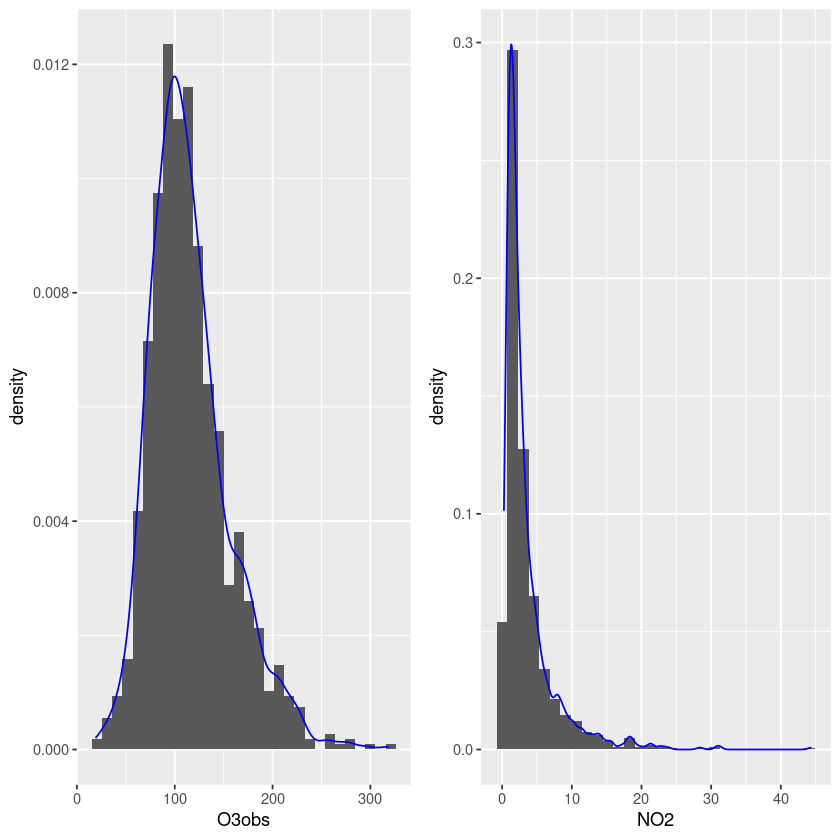

In [5]:
library(ggplot2)
library(gridExtra)
g1<-ggplot(ozone,aes(x=O3obs))+
  geom_histogram(aes(y=after_stat(density)))+
  geom_density(alpha=.2, col="blue") 
g2<-ggplot(ozone,aes(x=NO2))+
  geom_histogram(aes(y=..density..))+
  geom_density(alpha=.2, col="blue") 

grid.arrange(g1,g2,ncol=2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


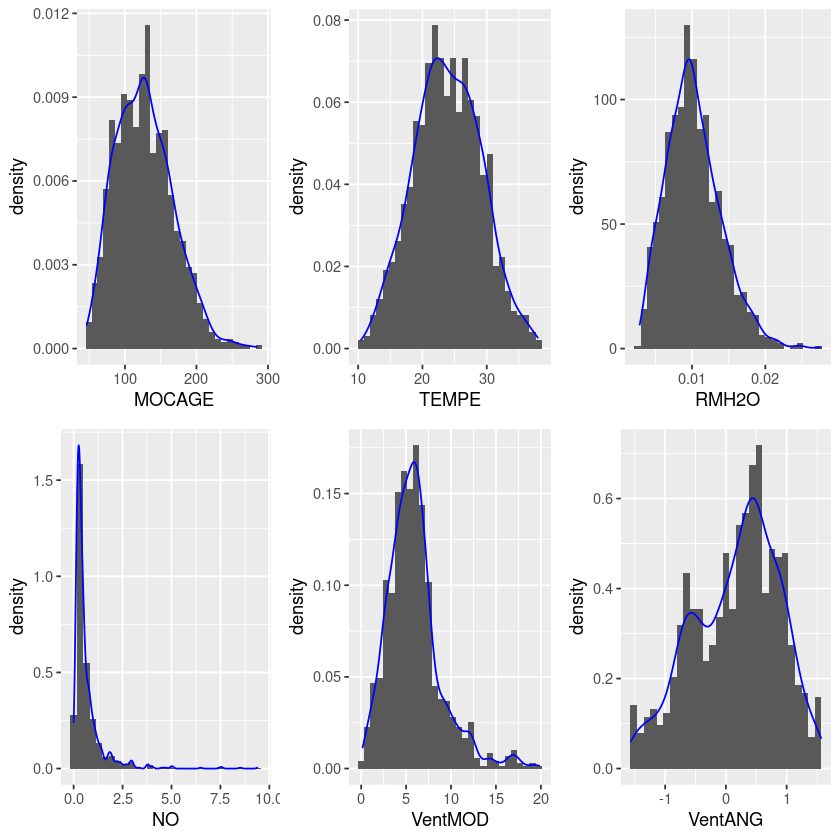

In [6]:
# Same thing for the other variables
g3<-ggplot(ozone,aes(x=MOCAGE))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g4<-ggplot(ozone,aes(x=TEMPE))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g5<-ggplot(ozone,aes(x=RMH2O))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g6<-ggplot(ozone,aes(x=NO))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g7<-ggplot(ozone,aes(x=VentMOD))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g8<-ggplot(ozone,aes(x=VentANG))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 

grid.arrange(g3,g4,g5,g6,g7,g8,ncol=3)
rm(g1,g2,g3,g4,g5,g6,g7,g8)

### Transformation of some  variables

Transformations are proposed to make some distributions more symmetric and thus more "Gaussian". This is necessary for some future modeling methods (linear), not for all (trees).


In [7]:
ozone[, "SRMH2O"] <- sqrt(ozone[, "RMH2O"])
ozone[, "LNO2"] <- log(ozone[, "NO2"])
ozone[, "LNO"] <- log(ozone[, "NO"])

**Question** Check the appropriateness of these transformations and then remove the initial variables

In [8]:

ozone <- ozone[, c(1:4, 8:13)]

We now build the `DepSeuil` threshold variable to get the file that will actually be used.

In [9]:
ozone[, "DepSeuil"] <- as.factor(ozone[, "O3obs"] > 150)
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:199  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Als:222  
         Median :109.0   Median :125.6   Median :23.80   Cad:202  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Pla:208  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   Ram:210  
         Max.   :319.0   Max.   :284.7   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931  
      LNO           

### Correlations of the  variables

**Question** What about the relationship of the variables 2 to 2 ? 

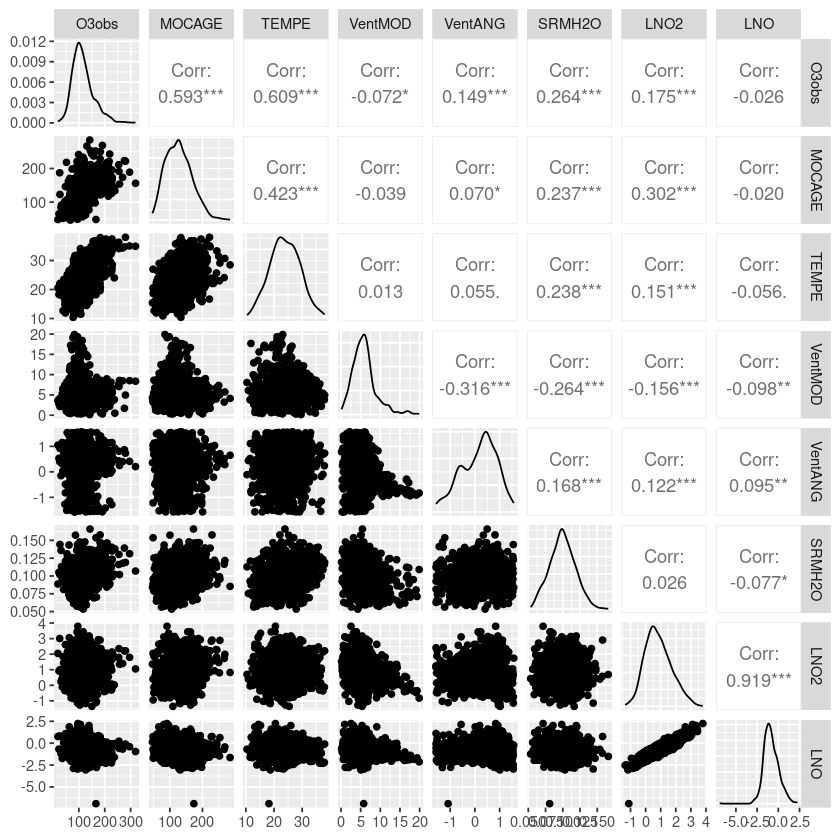

In [10]:
ggpairs(ozone[, c(2:4, 6:10)])

**Question** Complete by visualizing the correlations with the `corrplot()` function (package `corrplot`). What is the limitation of this type of numerical diagnosis : which type of correlation is measured? 

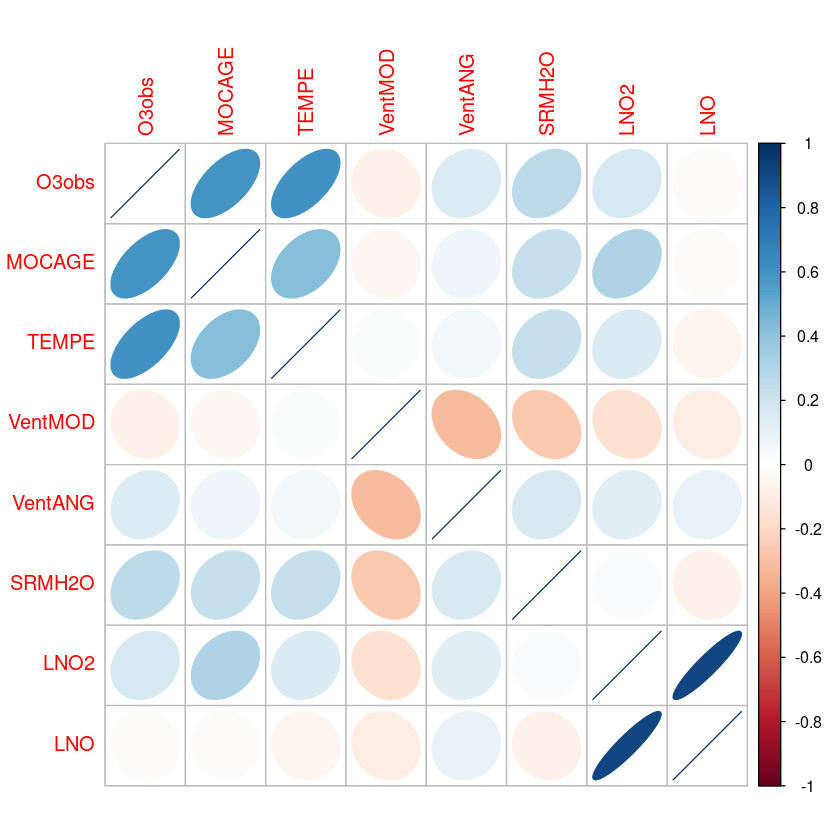

In [11]:
library(corrplot)
corrplot(cor(ozone[, c(2:4, 6:10)]),method="ellipse")

   ### Principal Components Analysis

The following commands allow to perform a [principal component analysis](http://wikistat.fr/pdf/st-m-explo-acp.pdf) (PCA) on the quantitative variables only. Moreover, the variable to be modeled (O3obs, observed concentration) is not used.

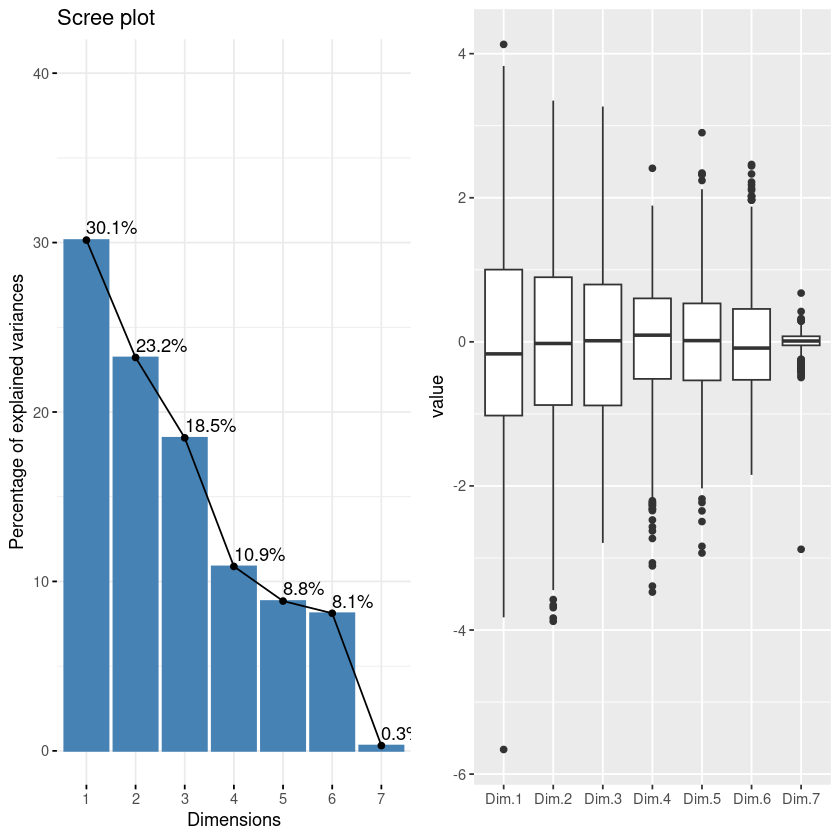

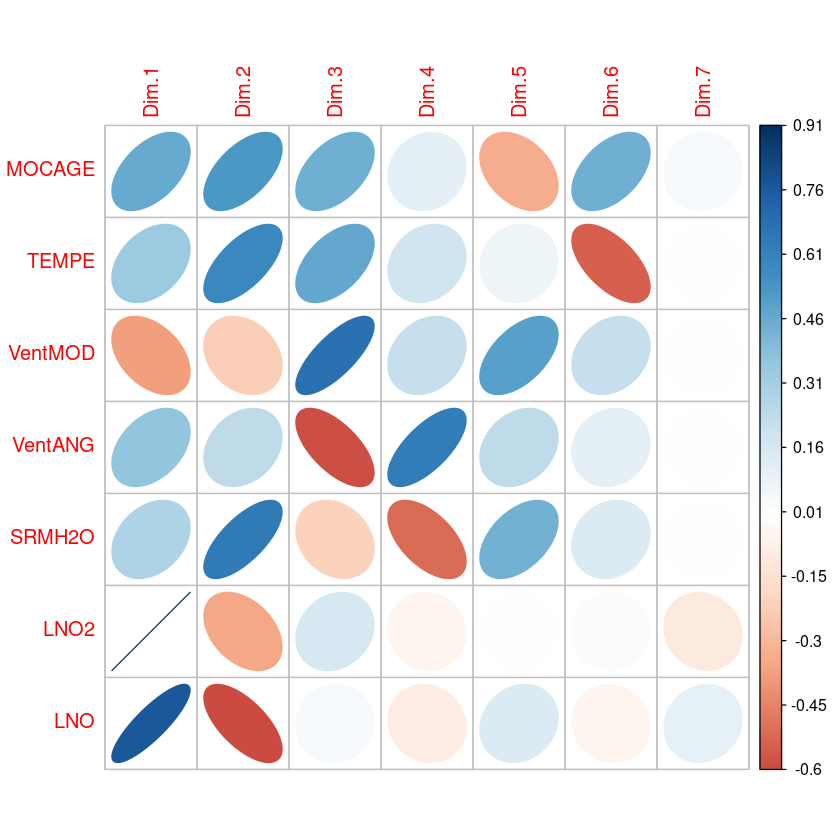

In [12]:
# Reduced PCA
library(FactoMineR)
acp <- PCA(ozone[, c(11,2:4, 6:10)], scale.unit = TRUE,
           graph = FALSE, quali.sup = 1, quanti.sup = 2, ncp = 7)
# Eigenvalue decay
library(factoextra)
g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))
library(reshape2)
g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)
# 
library(corrplot)
corrplot(acp$var$cor, is.corr=FALSE,method="ellipse")

In [13]:
help(PCA)

PCA {FactoMineR},R Documentation
X,a data frame with n rows (individuals) and p columns (numeric variables)
ncp,number of dimensions kept in the results (by default 5)
scale.unit,"a boolean, if TRUE (value set by default) then data are scaled to unit variance"
ind.sup,a vector indicating the indexes of the supplementary individuals
quanti.sup,a vector indicating the indexes of the quantitative supplementary variables
quali.sup,a vector indicating the indexes of the categorical supplementary variables
row.w,"an optional row weights (by default, a vector of 1 for uniform row weights); the weights are given only for the active individuals"
col.w,"an optional column weights (by default, uniform column weights); the weights are given only for the active variables"
graph,"boolean, if TRUE a graph is displayed"
axes,a length 2 vector specifying the components to plot


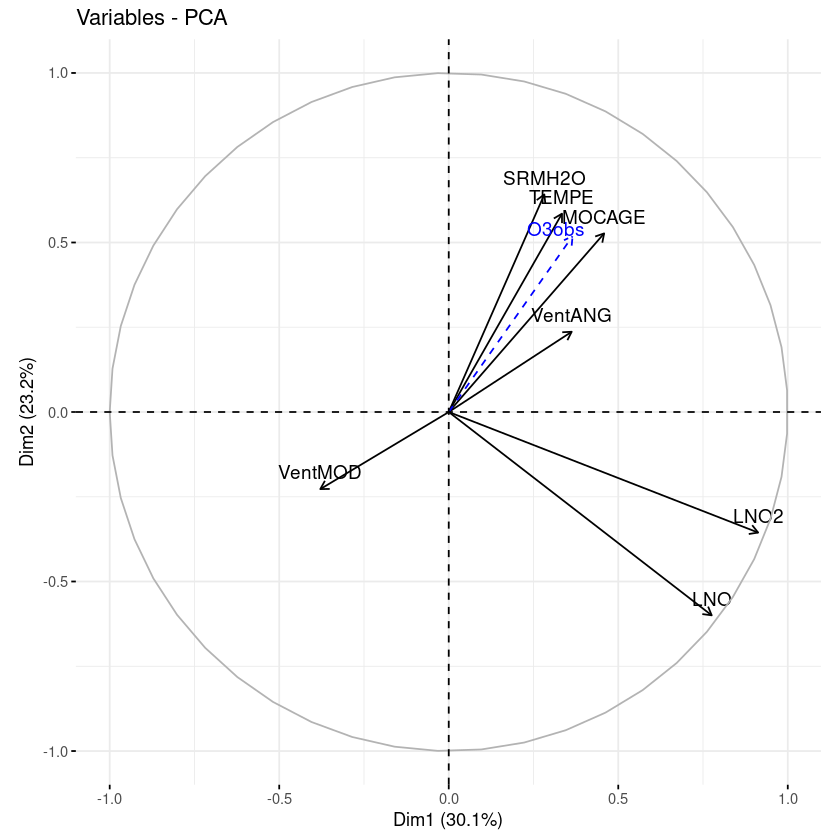

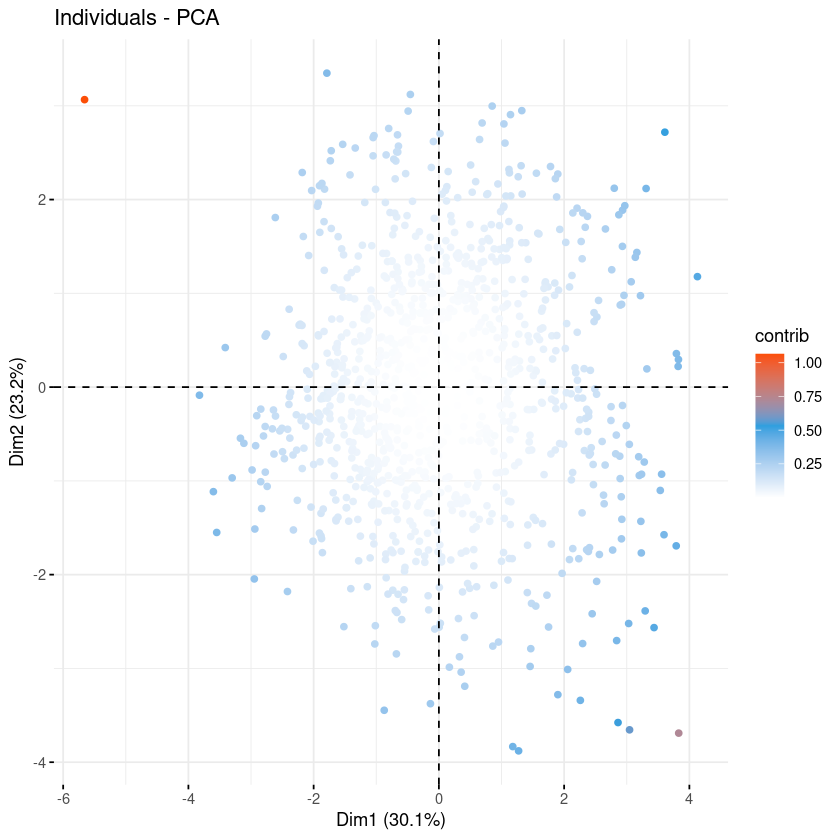

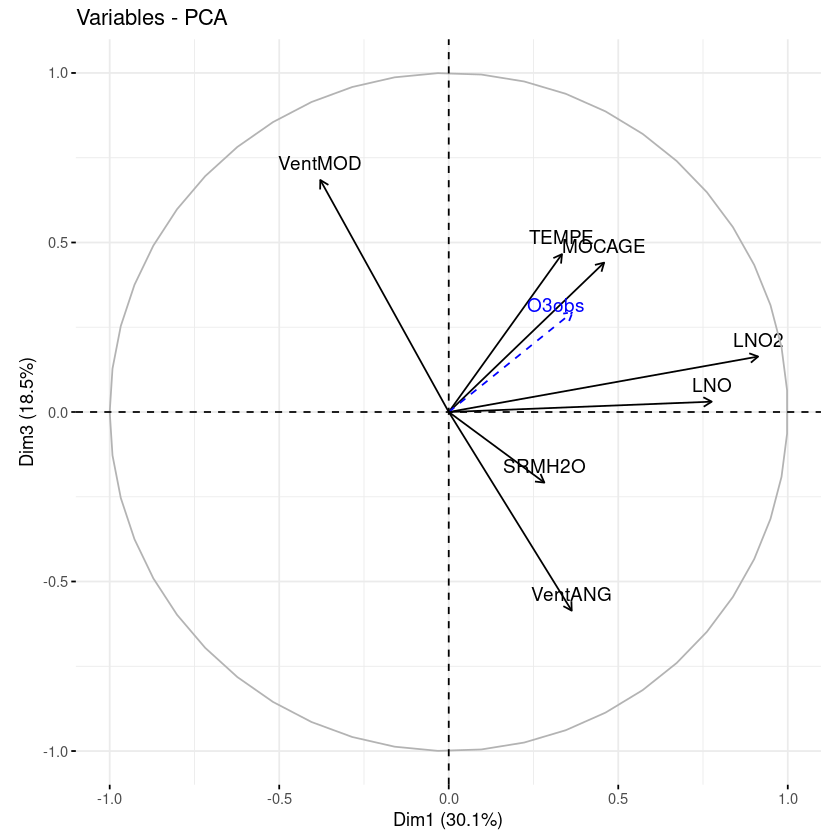

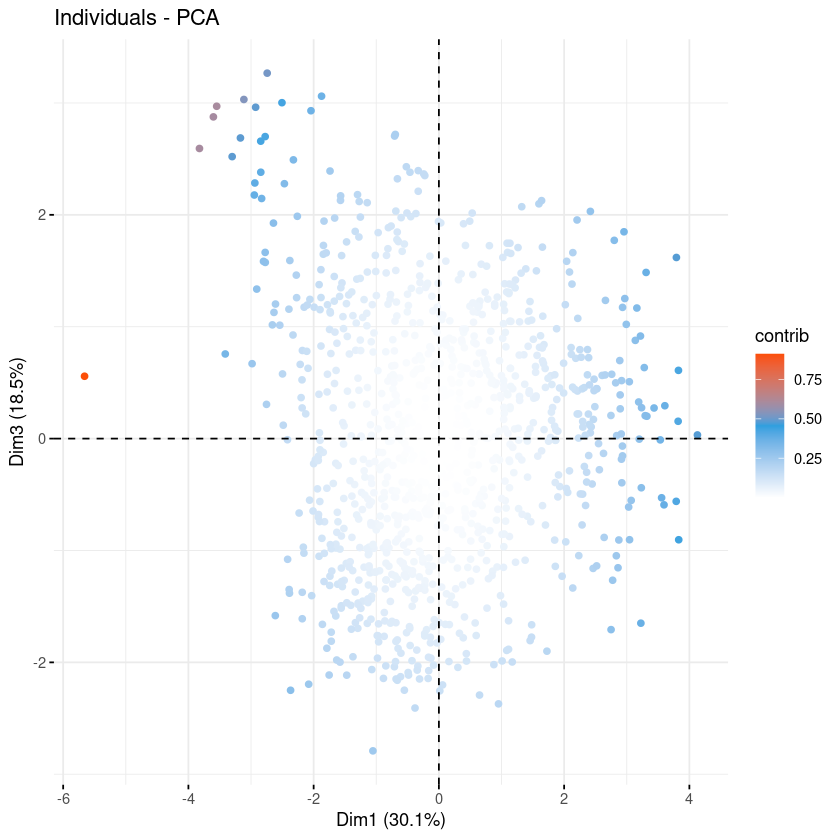

In [14]:
fviz_pca_var(acp)
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ))
fviz_pca_var(acp,axes=c(1,3))
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))

**Question** What do these different graphs represent?

**Question** What about the choice of the number of dimensions, the atypical values?

**Question** What about the correlation structure of the variables? Is it intuitive?


Same graph by coloring according to the threshold exceedance.

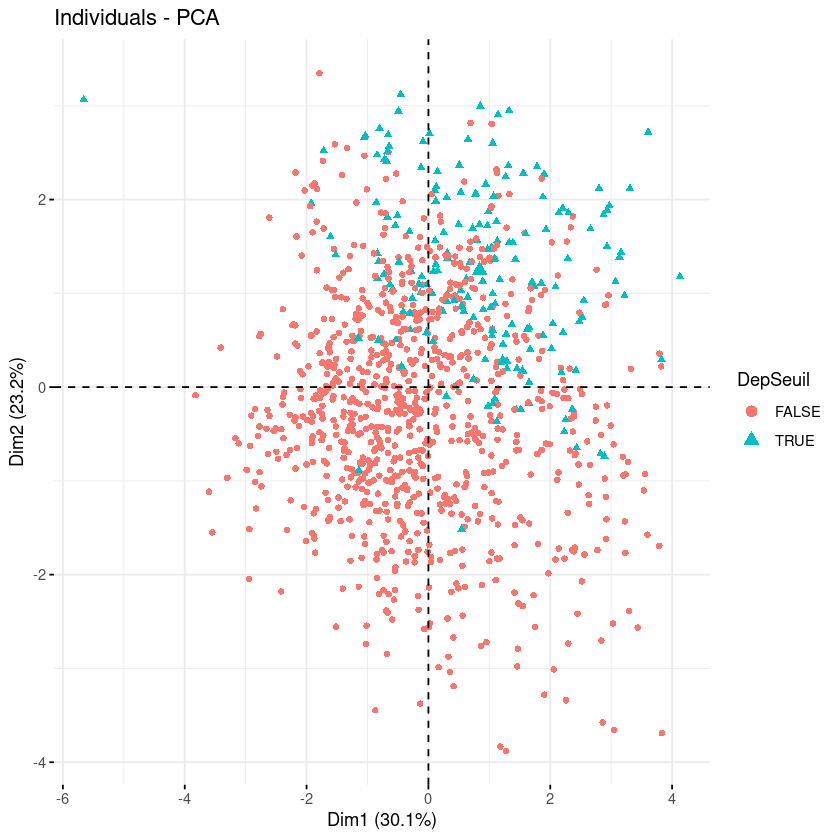

In [15]:
fviz_pca_ind(acp, label="none", habillage=1)

The objective is therefore to define a surface separating the two classes. 

**Question** Does a linear discrimination (hyperplane) seem possible? 

### Clustering

It is not useful here but an unsupervised classification is easy to obtain. For example in 2 classes, by the K-means algorithm. Does it give the same information? 

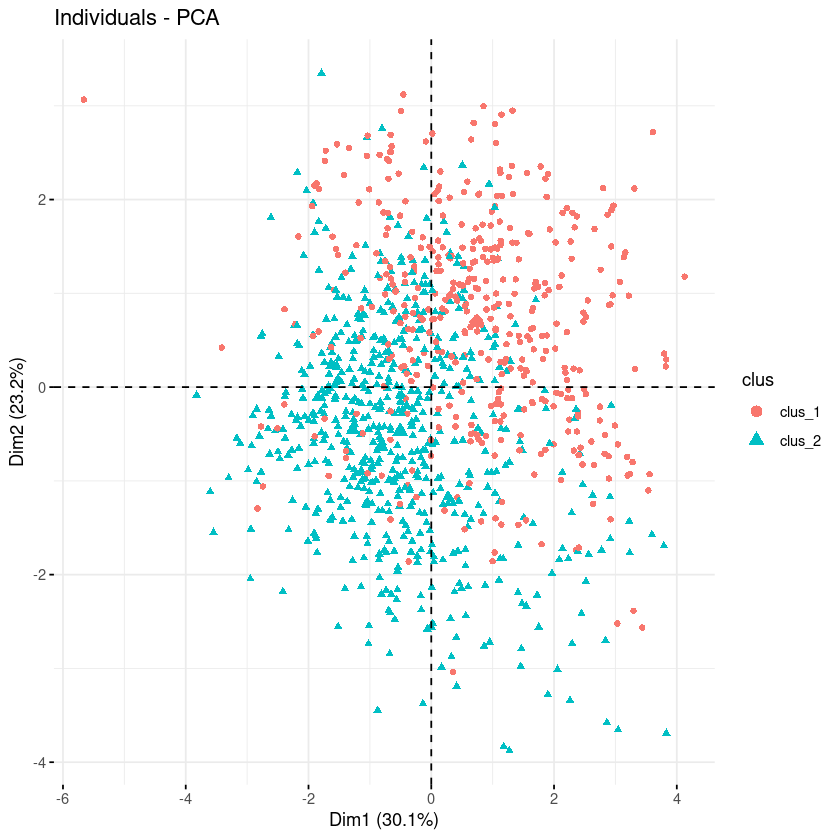

In [16]:
km.ozone <- kmeans(ozone[, c(3:4, 6:10)], centers = 2)
# Representation in the coordinates of the PCA
acp2 <- PCA(cbind(clus = as.factor(km.ozone$cluster),
          ozone[, c(11, 3:4, 6:10)]), scale.unit = TRUE,
          graph = FALSE, quali.sup = 1:2, ncp = 7)
fviz_pca_ind(acp2, label="none", habillage="clus")

## Comparison Protocol

### Strategy

The search for a better prediction method follows the following protocol.

1. Preliminary uni- and multidimensional descriptive steps to identify inconsistencies, non-significant or exotic distribution variables, irrelevant or atypical individuals... and to study the data structures. It can also be the long step of building specific variables, attributes or *features* of the data. 
2. Randomly draw a *test* sample that will only be used in the *last step* of comparing methods.
3. The remaining part is the *training* sample for estimating the parameters of the models.
4. For each of the methods, optimize the complexity of the models by minimizing an "unbiased" estimate of the prediction error, e.g., by [*cross validation*](http://wikistat.fr/pdf/st-m-app-risque.pdf):
    - Variables and interactions to be considered in linear or logistic regression;
    - variables and method for discriminant analysis;
    - number of leaves in the regression or classification tree;
    - architecture (number of neurons, penalization) of the perceptron;
    - aggregation algorithm, 
    - kernel and penalization of SVMs.
5.  Comparison of predictive qualities based on the misclassification rate for the  test sample.



### Remarks

* In the case of a relatively "small" sample, it is recommended to iterate the learning set /test set splitting procedure, in order to reduce the (average) variance of the risk estimates.

**Question** How is this specific cross-validation procedure called ? 

* *Beware*: do not "cheat" by modifying the model obtained in the previous step in order to improve the result on the test sample!
* The criterion used depends on the problem: squared error, misclassification rate, cross-entropy, AUC (area under the ROC curve) ...

### Extraction of the samples

The commands below perform the extraction of the subset of the training and test data. 

Use three random numbers, and **replace** "111" below, for the initialization of the random generator. Be aware that each participant draws a different sample, so it is normal not to get exactly the same results. 

In [17]:
set.seed(111) # initialization of the generator
# Extraction of the samples
test.ratio <- .2   # ratio of test sample
npop <- nrow(ozone) # number of lines in the data
nvar <- ncol(ozone) # number of columns
# size of the test sample
ntest <- ceiling(npop * test.ratio) 
# indices of the test sample
testi <- sample(1:npop, ntest)
# indices of the training sample
appri <- setdiff(1:npop, testi) 


Construction of the samples for the regression : ozone concentration prediction.

In [18]:
# construction of the training sample
datappr <- ozone[appri, -11] 
# construction of the test sample
datestr <- ozone[testi, -11] 
# verification
str(datappr)
str(datestr)
#summary(datappr) 

'data.frame':	832 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 2 2 1 ...
 $ O3obs  : int  91 100 82 94 107 150 164 135 121 129 ...
 $ MOCAGE : num  93.2 104.6 103.6 94.8 99 ...
 $ TEMPE  : num  21.5 20.2 17.4 18.8 23.7 23.6 26.6 23.5 23.3 23.7 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD: num  9.5 8.01 9.38 9.46 7.88 ...
 $ VentANG: num  -0.643 -0.05 -0.128 -0.345 -0.418 ...
 $ SRMH2O : num  0.092 0.0939 0.0975 0.0925 0.0855 ...
 $ LNO2   : num  0.471 0.752 0.505 0.854 0.503 ...
 $ LNO    : num  -0.858 -0.633 -0.761 -0.355 -0.794 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 1 1 1 2 1 1 1 2 2 2 ...
 $ O3obs  : int  135 143 71 77 79 155 101 75 114 156 ...
 $ MOCAGE : num  127.8 189.7 103.9 73 87.8 ...
 $ TEMPE  : num  18.8 21 25.9 23.5 12.3 32.2 19.4 27.6 24.9 27 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 3 4 1 5 5 1 2 3 4 2 ...
 $ VentMOD: num  2.1 3.14 10

Construction of the samples for the classification : prediction of threshold overflow.

In [19]:
# construction of the training sample
datappq <- ozone[appri,-2]
# construction of the test sample
datestq <- ozone[testi,-2] 

# verification
str(datappq)
str(datestq)
#summary(datappq)

'data.frame':	832 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 2 2 1 ...
 $ MOCAGE  : num  93.2 104.6 103.6 94.8 99 ...
 $ TEMPE   : num  21.5 20.2 17.4 18.8 23.7 23.6 26.6 23.5 23.3 23.7 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD : num  9.5 8.01 9.38 9.46 7.88 ...
 $ VentANG : num  -0.643 -0.05 -0.128 -0.345 -0.418 ...
 $ SRMH2O  : num  0.092 0.0939 0.0975 0.0925 0.0855 ...
 $ LNO2    : num  0.471 0.752 0.505 0.854 0.503 ...
 $ LNO     : num  -0.858 -0.633 -0.761 -0.355 -0.794 ...
 $ DepSeuil: Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 1 2 1 1 1 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 1 1 1 2 1 1 1 2 2 2 ...
 $ MOCAGE  : num  127.8 189.7 103.9 73 87.8 ...
 $ TEMPE   : num  18.8 21 25.9 23.5 12.3 32.2 19.4 27.6 24.9 27 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 3 4 1 5 5 1 2 3 4 2 ...
 $ VentMOD : num  2.1 3.14 10.68 4.3 4.6 ...
 $ VentANG : 

**Note**: We have here "manually" done the construction of the samples for pedagogical purposes. In practice, one can use R functions that do this work, in particular the `createDataPartition` function of the `caret` library. 


Finally, before moving on to the different algorithms, let's define a function plotting the graph of the residuals with fixed colors and scales on the axes. 


In [20]:
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+xlim(0, 250)+ylim(-150, 150)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

## [Prediction by linear Gaussian model](http://wikistat.fr/pdf/st-m-app-select.pdf)

The first model to be tested is a simple linear Gaussian model but, as some variables are qualitative, it is an analysis of covariance. On the other hand, we are interested in knowing if interactions are to be taken into account. The model then becomes polynomial of order 2 or quadratic.

### Linear model

#### Without variable selection

The linear model integrates categorical variables; it is in this case an *analysis of covariance* estimated by the `aov` function better adapted to this model.

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


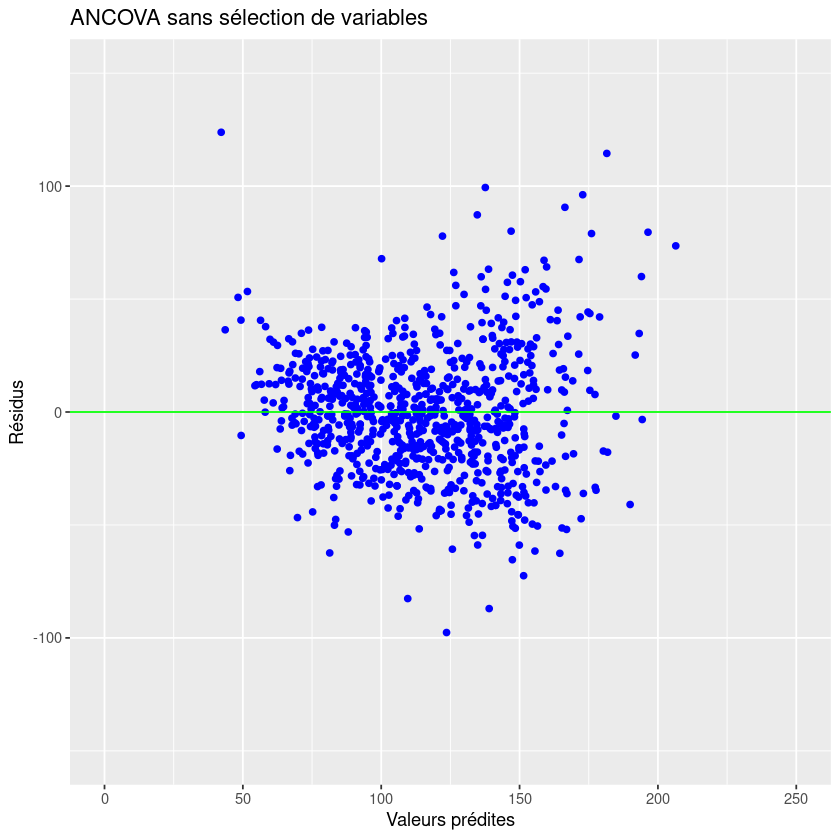

In [21]:
# estimation of the model without interaction
reg.lm <-aov(O3obs ~ . , data = datappr)
# Extraction of residuals and fitted values from this model
res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values
# Graph of the residuals
gplot.res(fit.lm,res.lm,"ANCOVA sans sélection de variables")

**Question** What about the distribution of these residuals? 

**Question** The shape of the cloud gives information about the assumptions of linearity and homoscedasticity of the model. What about the validity of this model?

Nevertheless, assess its significance by the following command.



In [22]:
summary(reg.lm)

             Df Sum Sq Mean Sq F value   Pr(>F)    
JOUR          1    106     106   0.134 0.714791    
MOCAGE        1 470173  470173 590.680  < 2e-16 ***
TEMPE         1 225427  225427 283.204  < 2e-16 ***
STATION       4  10163    2541   3.192 0.012926 *  
VentMOD       1  13846   13846  17.395 3.36e-05 ***
VentANG       1  10088   10088  12.673 0.000392 ***
SRMH2O        1    273     273   0.343 0.558101    
LNO2          1   3337    3337   4.193 0.040918 *  
LNO           1   9006    9006  11.314 0.000805 ***
Residuals   819 651913     796                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [23]:
coef(reg.lm)

(Intercept)       JOUR1      MOCAGE       TEMPE  STATIONAls  STATIONCad 
-16.0273451   1.2144463   0.3849814   4.3270454   2.1425958   8.8115799 
 STATIONPla  STATIONRam     VentMOD     VentANG      SRMH2O        LNO2 
 21.0287164   3.4628151  -1.3756918   4.5070677  52.5682991 -14.2991137 
        LNO 
 16.9322029

**Question** This first model is compared with that of the only deterministic forecast MOCAGE. What can we conclude?

Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


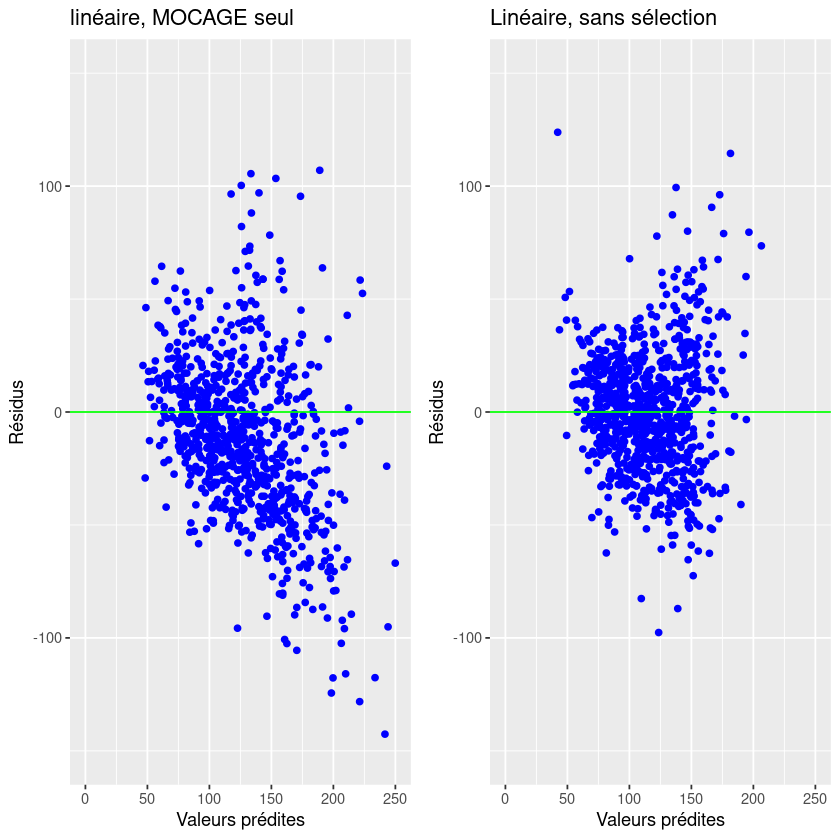

In [24]:
# Residuals plot of the deterministic model MOCAGE
g1<-gplot.res(datappr[, "MOCAGE"],datappr[, "O3obs"]-datappr[, "MOCAGE"], "linéaire, MOCAGE seul")

g2<-gplot.res(fit.lm, res.lm, "Linéaire, sans sélection")
grid.arrange(g1,g2,ncol=2)

#### Variable selection with  L1 regularisation (LASSO)

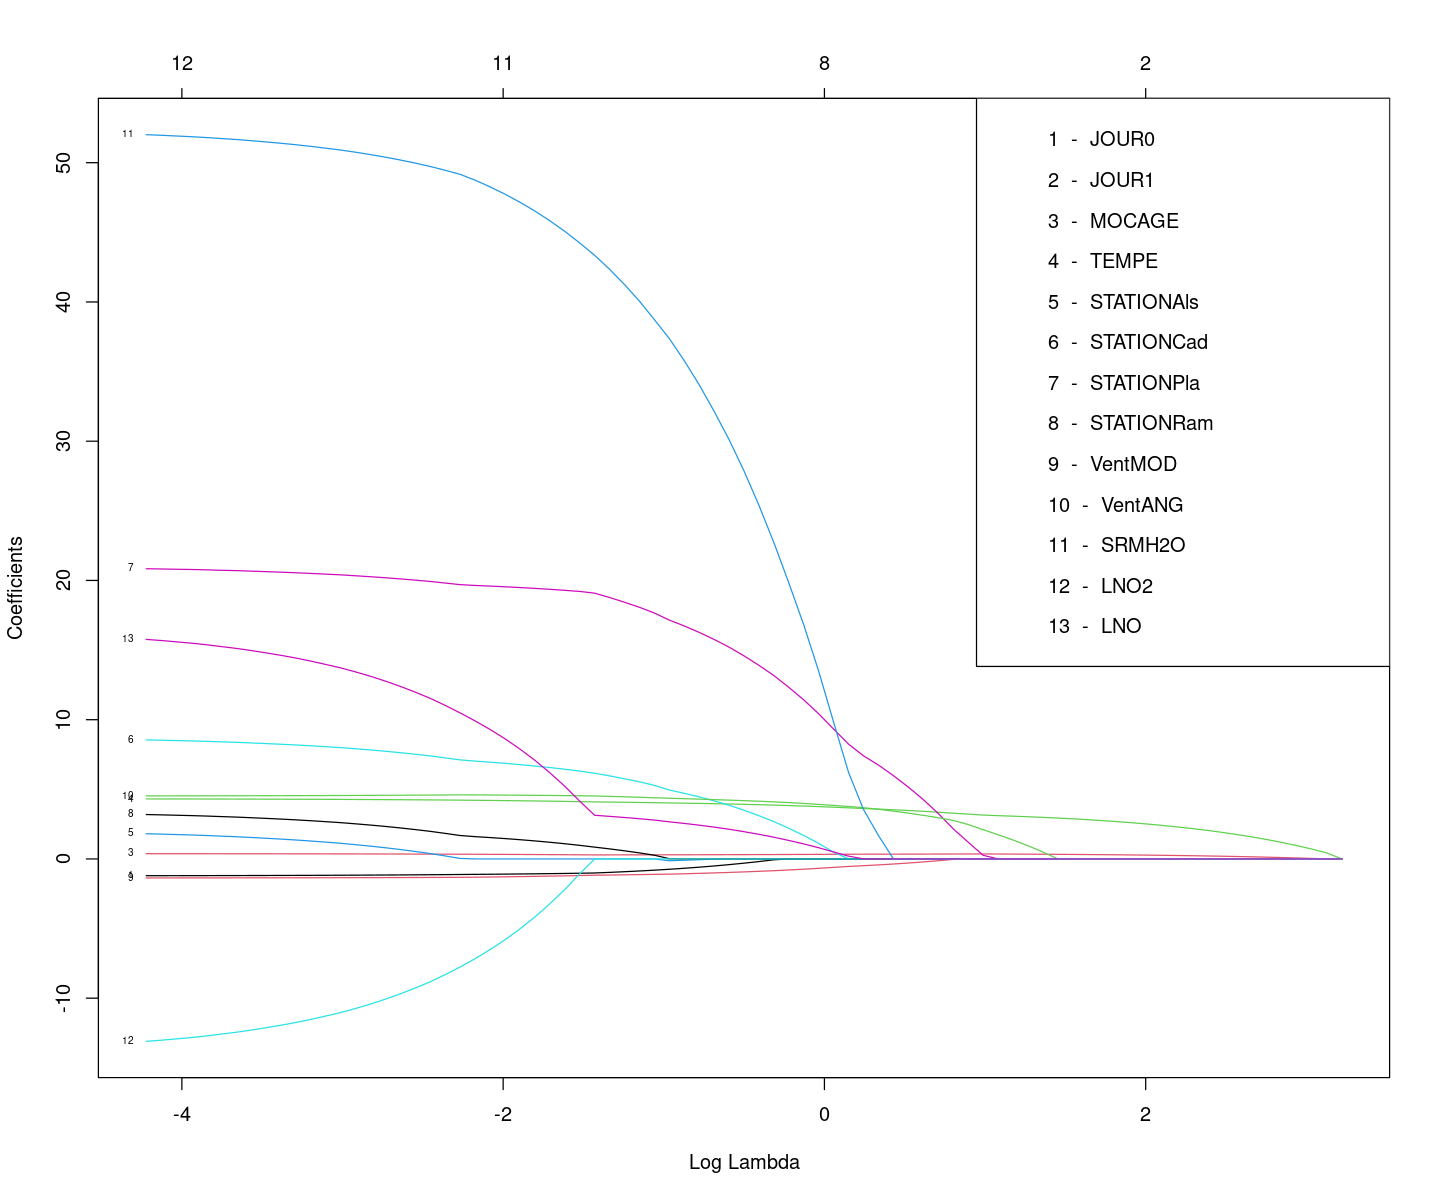

In [25]:
library(glmnet)
# with quantitatives variables only
reg.lasso.quanti <- glmnet(y = datappr[, 2],
                           x = as.matrix(datappr[, -c(1, 2, 5)]))
# with all the variables, create first the matrix of experiments 
# with 'model.matrix' (remember to remove the intercept from the model)
x.mat <- model.matrix(O3obs ~ . - 1, data = datappr)
reg.lasso <- glmnet(y = datappr$O3obs, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

**Question** What does the model.matrix command do? How are the categorical variables handled?

In [26]:
#help(model.matrix)
head(x.mat)

,JOUR0,JOUR1,MOCAGE,TEMPE,STATIONAls,STATIONCad,STATIONPla,STATIONRam,VentMOD,VentANG,SRMH2O,LNO2,LNO
1,0,1,93.2,21.5,0,0,0,0,9.5000,-0.64350,0.09203260,0.4712528,-0.8580218
2,0,1,104.6,20.2,0,0,0,0,8.0100,-0.04996,0.09386160,0.7518877,-0.6329933
3,1,0,103.6,17.4,0,0,0,0,9.3771,-0.12832,0.09751923,0.5050087,-0.7614260
4,1,0,94.8,18.8,0,0,0,0,9.4578,-0.34516,0.09246621,0.8544153,-0.3552474
5,1,0,99.0,23.7,0,0,0,0,7.8791,-0.41822,0.08549854,0.5025918,-0.7940731
6,1,0,114.3,23.6,0,0,0,0,6.3127,0.06341,0.10871982,1.6707211,0.2949059


**Question** What do the above curves, called "regularization paths", represent?

We then focus on the choice of the regularization parameter by cross-validation: 

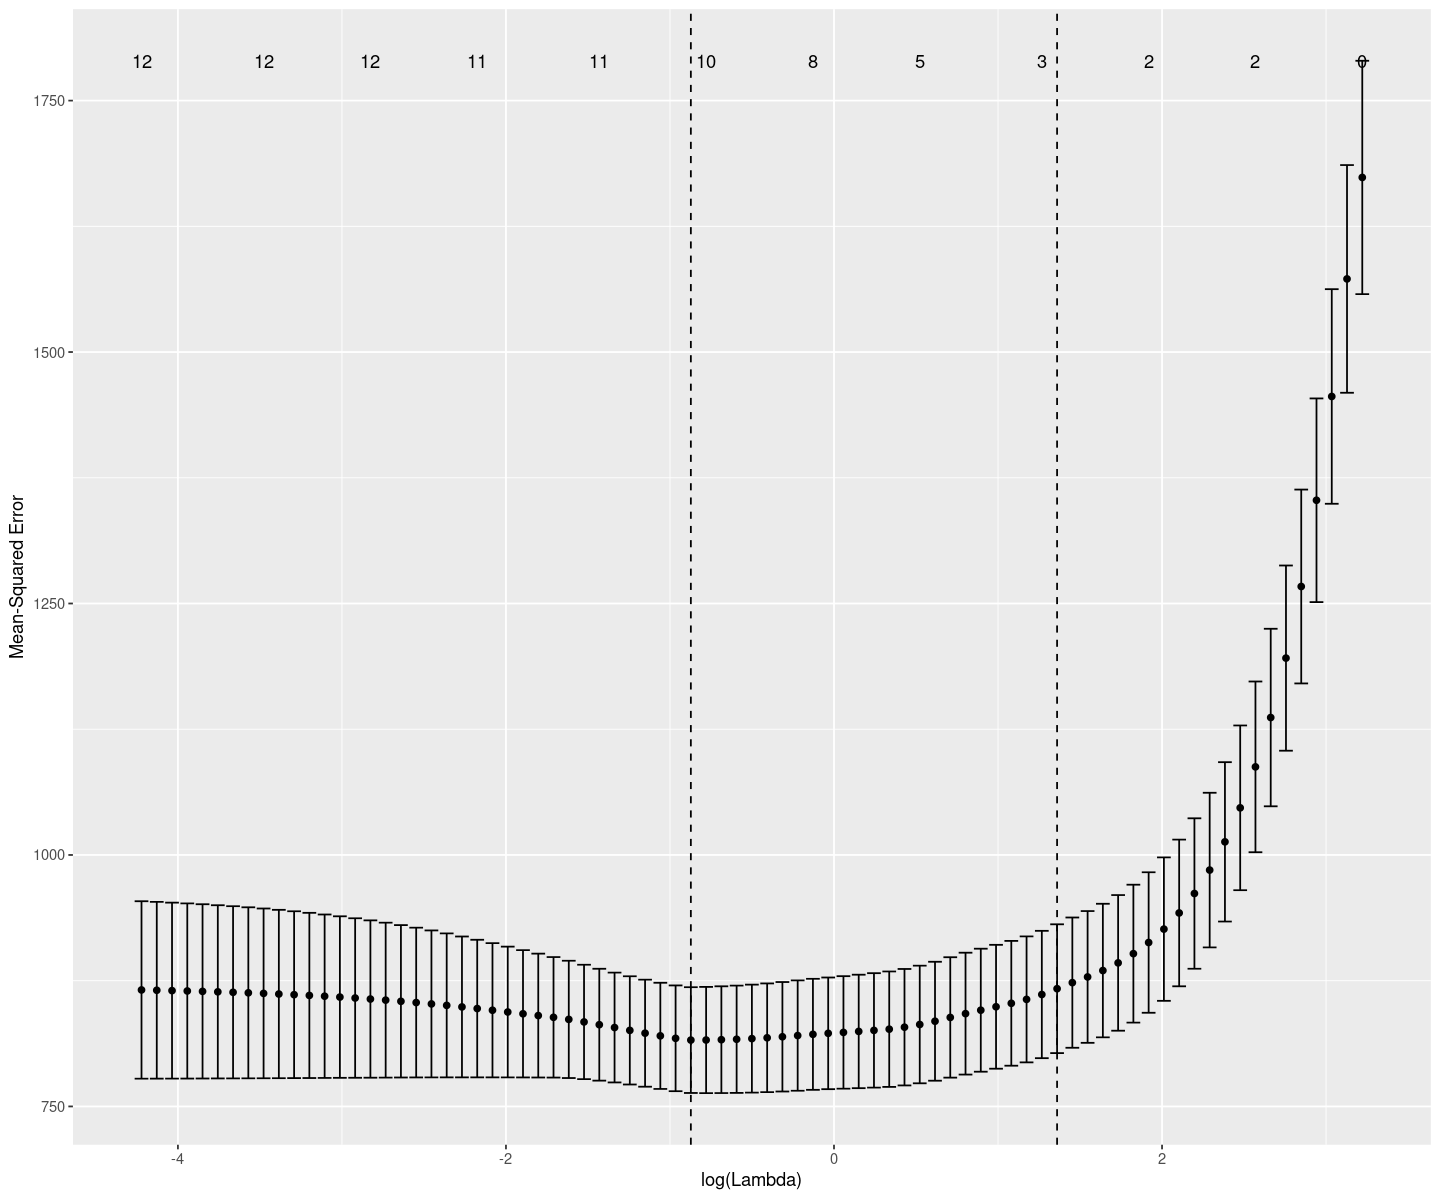

In [27]:
reg.lasso.cv <- cv.glmnet(y = datappr[, 2], x = x.mat)
#plot(reg.lasso.cv)
autoplot(reg.lasso.cv)

In [28]:
library(glmnet)
help(cv.glmnet)

cv.glmnet {glmnet},R Documentation
x,x matrix as in glmnet.
y,response y as in glmnet.
weights,Observation weights; defaults to 1 per observation
offset,Offset vector (matrix) as in glmnet
lambda,"Optional user-supplied lambda sequence; default is NULL, and glmnet chooses its own sequence. Note that this is done for the full model (master sequence), and separately for each fold. The fits are then alligned using the master sequence (see the allignment argument for additional details). Adapting lambda for each fold leads to better convergence. When lambda is supplied, the same sequence is used everywhere, but in some GLMs can lead to convergence issues."
type.measure,"loss to use for cross-validation. Currently five options, not all available for all models. The default is type.measure=""deviance"", which uses squared-error for gaussian models (a.k.a type.measure=""mse"" there), deviance for logistic and poisson regression, and partial-likelihood for the Cox model. type.measure=""class"" applies to binomial and multinomial logistic regression only, and gives misclassification error. type.measure=""auc"" is for two-class logistic regression only, and gives area under the ROC curve. type.measure=""mse"" or type.measure=""mae"" (mean absolute error) can be used by all models except the ""cox""; they measure the deviation from the fitted mean to the response. type.measure=""C"" is Harrel's concordance measure, only available for cox models."
nfolds,"number of folds - default is 10. Although nfolds can be as large as the sample size (leave-one-out CV), it is not recommended for large datasets. Smallest value allowable is nfolds=3"
foldid,"an optional vector of values between 1 and nfolds identifying what fold each observation is in. If supplied, nfolds can be missing."
alignment,"This is an experimental argument, designed to fix the problems users were having with CV, with possible values ""lambda"" (the default) else ""fraction"". With ""lambda"" the lambda values from the master fit (on all the data) are used to line up the predictions from each of the folds. In some cases this can give strange values, since the effective lambda values in each fold could be quite different. With ""fraction"" we line up the predictions in each fold according to the fraction of progress along the regularization. If in the call a lambda argument is also provided, alignment=""fraction"" is ignored (with a warning)."
grouped,"This is an experimental argument, with default TRUE, and can be ignored by most users. For all models except the ""cox"", this refers to computing nfolds separate statistics, and then using their mean and estimated standard error to describe the CV curve. If grouped=FALSE, an error matrix is built up at the observation level from the predictions from the nfolds fits, and then summarized (does not apply to type.measure=""auc""). For the ""cox"" family, grouped=TRUE obtains the CV partial likelihood for the Kth fold by subtraction; by subtracting the log partial likelihood evaluated on the full dataset from that evaluated on the on the (K-1)/K dataset. This makes more efficient use of risk sets. With grouped=FALSE the log partial likelihood is computed only on the Kth fold"


**Question** What do the bold dots represent? What about the band around them? 

**Question** How are the log(lambda) values corresponding to the vertical dotted lines obtained?

In [29]:
# estimated value
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# corresponding model
coef(reg.lasso.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 3.896"

14 x 1 sparse Matrix of class "dgCMatrix"
                   s1
(Intercept) 1.1658431
JOUR0       .        
JOUR1       .        
MOCAGE      0.3370194
TEMPE       2.9855716
STATIONAls  .        
STATIONCad  .        
STATIONPla  .        
STATIONRam  .        
VentMOD     .        
VentANG     0.4939697
SRMH2O      .        
LNO2        .        
LNO         .        

**Question** How many non-zero coefficients are left. Check on the regularization paths.

**Question** Same question by choosing the other value of lambda retained by glmnet, i.e. `reg.lasso.cv$lambda.min`

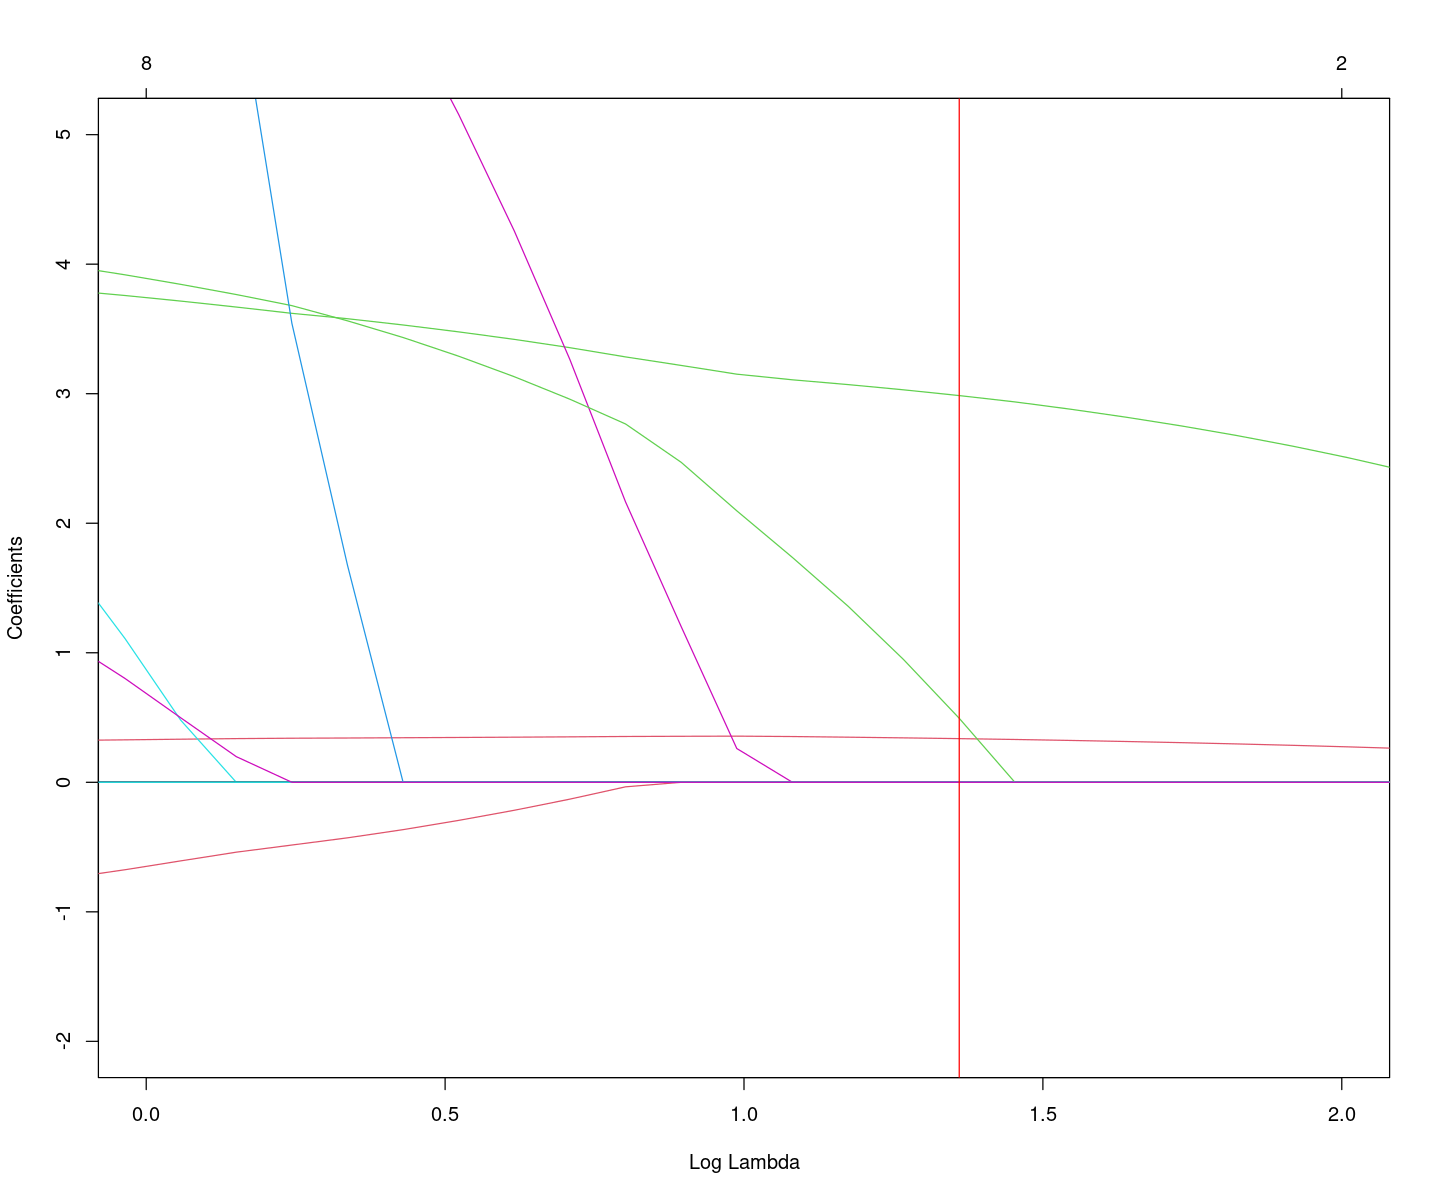

In [30]:
plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(0,2),ylim=c(-2,5))
abline(v=log(reg.lasso.cv$lambda.1se),col="red")

[1] "CV estimate of lambda : 0.418"

14 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) -18.02986736
JOUR0        -0.67101204
JOUR1         .         
MOCAGE        0.29912279
TEMPE         4.00531665
STATIONAls   -0.09333231
STATIONCad    4.71348395
STATIONPla   16.73098026
STATIONRam    .         
VentMOD      -1.06568750
VentANG       4.32796699
SRMH2O       35.78513984
LNO2          .         
LNO           2.55034443

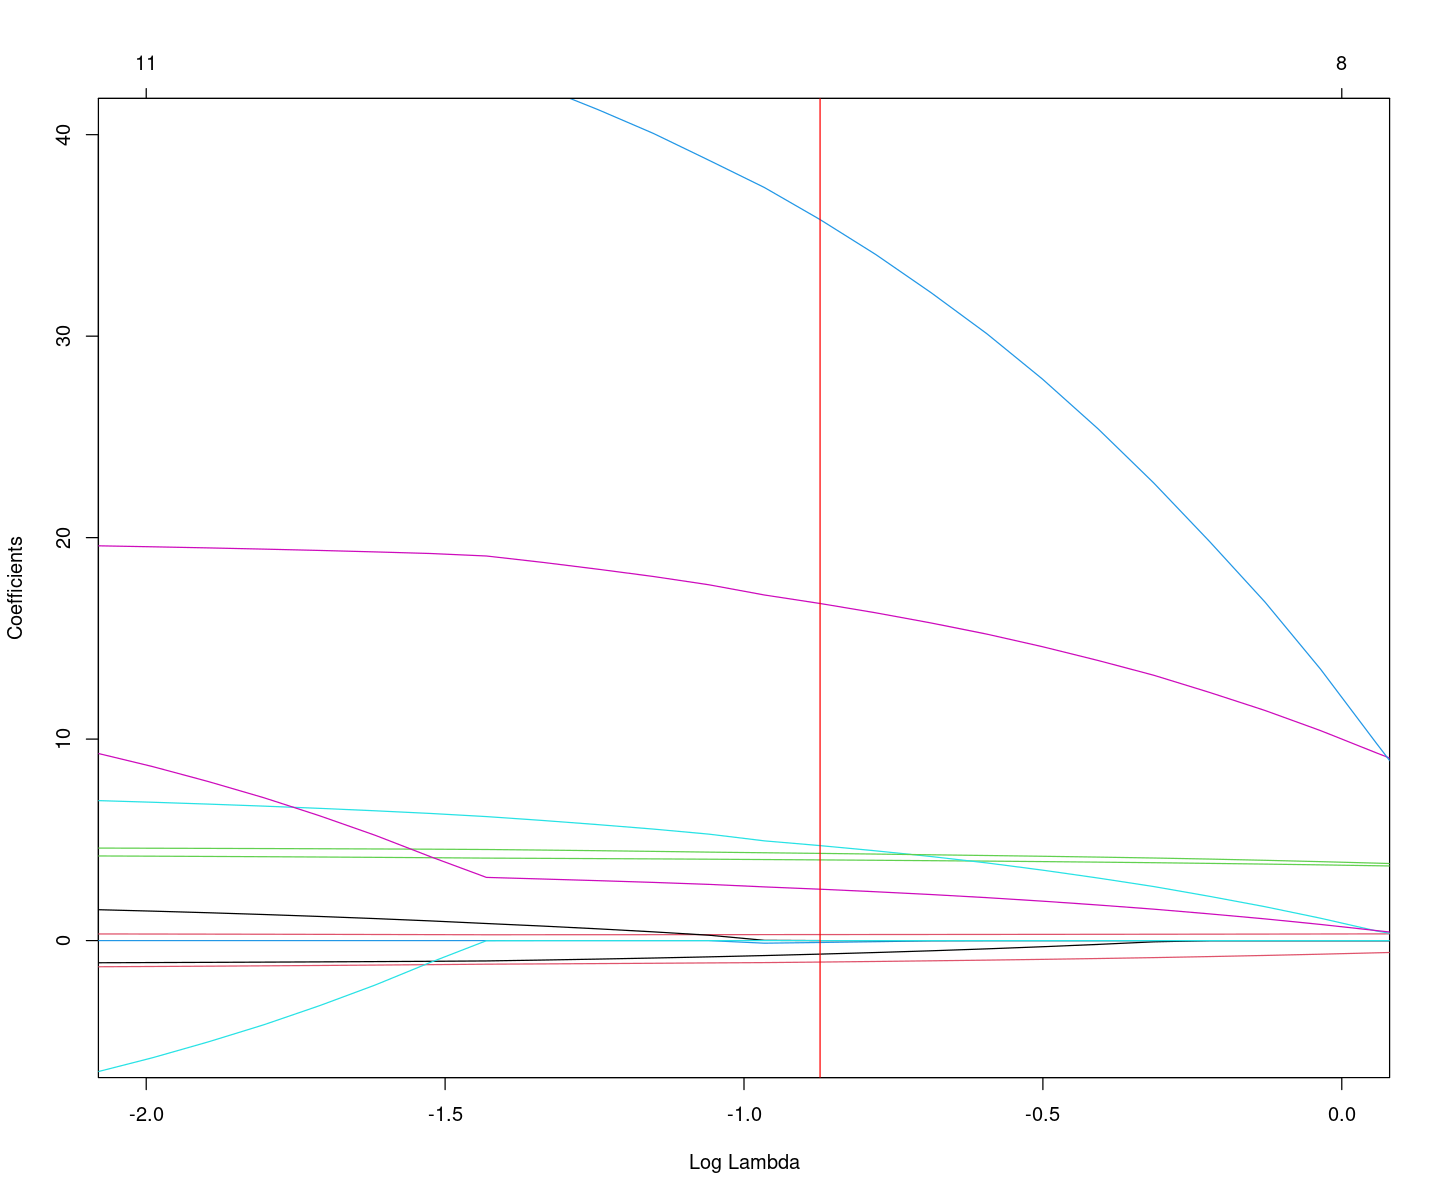

In [31]:
# estimated value
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.min, 3))
# corresponding model
coef(reg.lasso.cv, s = "lambda.min")

plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(-2,0),ylim=c(-5,40))
abline(v=log(reg.lasso.cv$lambda.min),col="red")

We then plot the residuals against the predicted values. 

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


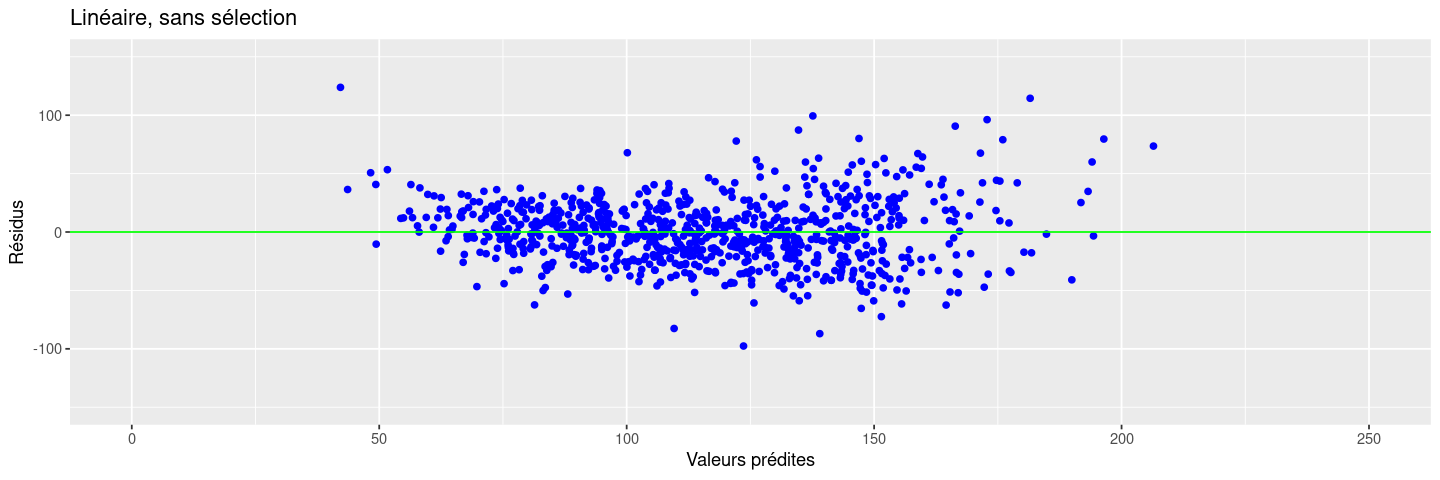

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


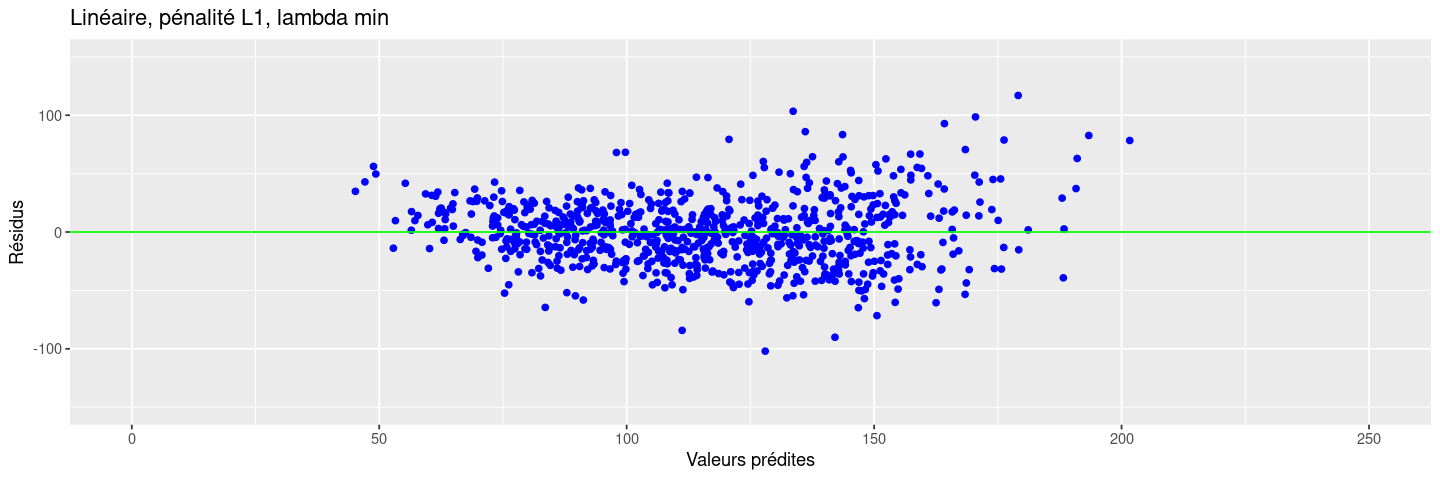

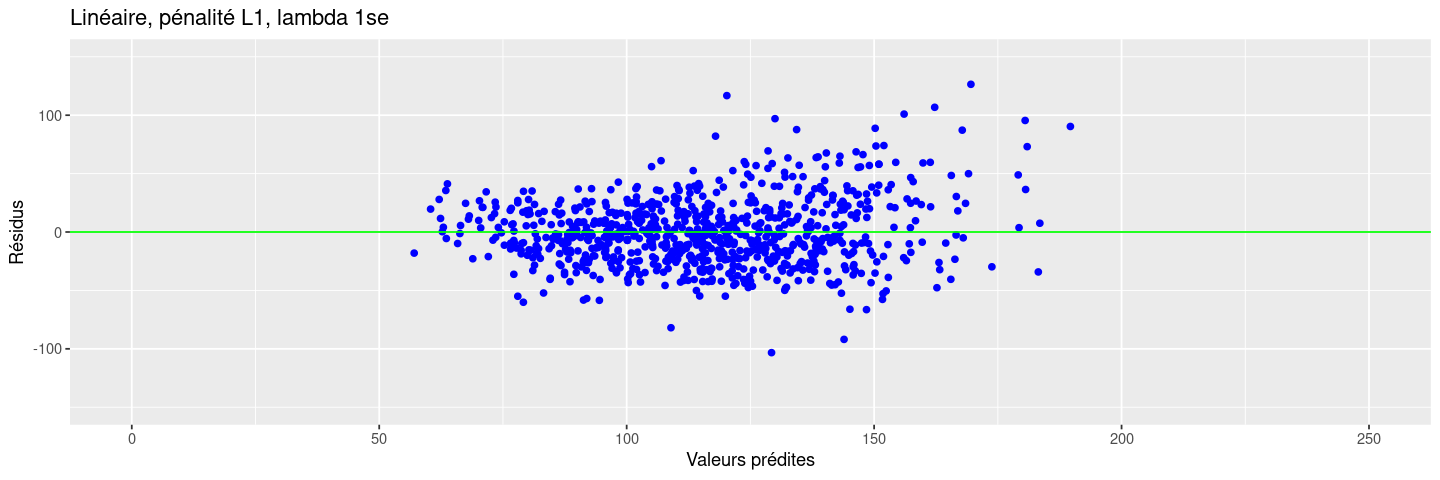

In [32]:
# Extraction of fitted values and residuals

fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- datappr$O3obs - fit.lasso

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)
res.lasso.1se <- datappr$O3obs - fit.lasso.1se 

# Graph of the residuals
options(repr.plot.width = 12, repr.plot.height = 4)
par(mfrow = c(1, 3))
gplot.res(fit.lm, res.lm, "Linéaire, sans sélection")
gplot.res(fit.lasso, res.lasso, "Linéaire, pénalité L1, lambda min")
gplot.res(fit.lasso.1se, res.lasso.1se, "Linéaire, pénalité L1, lambda 1se") 

summary(svm.Cub.poly.tune)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 coef0
     1

- best performance: 0.04 

- Detailed performance results:
   coef0 error dispersion
1     -5 0.190 0.09660918
2     -4 0.195 0.10394977
3     -3 0.205 0.10394977
4     -2 0.230 0.10852547
5     -1 0.270 0.09189366
6      0 0.095 0.07245688
7      1 0.040 0.04594683
8      2 0.050 0.05270463
9      3 0.050 0.05270463
10     4 0.055 0.04972145
11     5 0.050 0.05270463

Q: What value of coef0 is obtained by cross validation? What is the generalization error in this case?
**Question** Comment. 

**Question** Calculate the MSE criterion (mean square of residuals) for the two models. Why is the one obtained by LASSO worse? Which criterion does LASSO minimize?

In [33]:
paste("Modèle linéaire sans sélection:",mean(res.lm^2))
paste("LASSO avec lambda.min:",mean(res.lasso^2))
paste("LASSO avec lambda.1se:",mean(res.lasso.1se^2))

[1] "Modèle linéaire sans sélection: 783.549239590938"

[1] "LASSO avec lambda.min: 793.58476401389"

[1] "LASSO avec lambda.1se: 859.648320971249"

**Question** Estimate the error of the simple linear model without variable selection by cross validation. Compare with the LASSO error. What do you observe?

In [34]:
V=10 ; nV=floor(nrow(datappr)/V)
S=sample(1:nrow(datappr),replace=FALSE)
error.CV = c()
for(v in 1:V)
{  #
    datappr.learn=datappr[-c(S[(nV*(v-1)):(nV*v)]),] 
    datappr.valid=datappr[c(S[(nV*(v-1)):(nV*v)]),]
    error.CV=c(error.CV,mean((datappr.valid$O3obs-predict(aov(O3obs ~ ., data=datappr.learn),newdata=datappr.valid))^2))
}
mean(error.CV)

print(reg.lasso.cv)

[1] 865.6682


Call:  cv.glmnet(x = x.mat, y = datappr[, 2]) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  0.418    45   815.9 52.58      10
1se  3.896    21   867.0 64.04       3


### Quadratic model

The following study implements all the second-order interactions between the variables. It is therefore a quadratic regression model. It is estimated with the function `glm()` which allows an automatic model selection. The backward method is used but the stepwise method could also be used. This type of procedure is not implemented in Python.


#### Variable selection with AIC criterion

Backward selection : at each step, each model is compared to all possible sub-models obtained by deleting one of the interactions or one of the variables, provided that it is not present in an interaction. The selected and deleted variable is the one that decreases the most the considered criterion: AIC (*Akaïke Information Criterion*). 

**Question** Which other criterion, equivalent to AIC in the Gaussian case and of known residual variance, is used in linear regression? 


In [35]:
# Model estimation  with all interactions  of order 2
reg.glm <- glm(O3obs ~ .^2, data = datappr)
# Search for the best model in the sense 
# of the Akaïke criterion by backward method
reg.glm.step <- step(reg.glm, direction = "backward")

Start:  AIC=7783.44
O3obs ~ (JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO)^2

                  Df Deviance    AIC
- JOUR:STATION     4   471877 7776.5
- STATION:VentANG  4   471970 7776.7
- JOUR:TEMPE       1   471262 7781.4
- JOUR:LNO2        1   471262 7781.4
- LNO2:LNO         1   471263 7781.4
- JOUR:SRMH2O      1   471265 7781.4
- MOCAGE:TEMPE     1   471270 7781.5
- JOUR:LNO         1   471321 7781.5
- JOUR:MOCAGE      1   471324 7781.6
- VentMOD:VentANG  1   471374 7781.6
- JOUR:VentANG     1   471464 7781.8
- MOCAGE:VentANG   1   471510 7781.9
- MOCAGE:STATION   4   475115 7782.2
- JOUR:VentMOD     1   471774 7782.3
- VentANG:SRMH2O   1   471804 7782.4
- MOCAGE:SRMH2O    1   471846 7782.5
- VentMOD:LNO2     1   472012 7782.8
- TEMPE:VentMOD    1   472318 7783.3
<none>                 471261 7783.4
- VentMOD:LNO      1   472416 7783.5
- MOCAGE:VentMOD   1   472452 7783.5
- STATION:LNO      4   476488 7784.6
- VentANG:LNO2     1   473094 7784.7


In [36]:
# Coefficients  of the model
anova(reg.glm.step, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,831,1394332.0,NA,NA
MOCAGE,1,469071.2081,830,925260.8,763.8571548,3.647061e-118
TEMPE,1,225512.0241,829,699748.7,367.2341644,1.630666e-67
STATION,4,10252.6125,825,689496.1,4.1739566,2.371040e-03
VentMOD,1,14316.7164,824,675179.4,23.3140002,1.652264e-06
VentANG,1,10355.9415,823,664823.5,16.8640919,4.433664e-05
SRMH2O,1,244.5782,822,664578.9,0.3982825,5.281601e-01
LNO2,1,3273.0334,821,661305.9,5.3299583,2.121919e-02
LNO,1,9138.5263,820,652167.3,14.8815971,1.238032e-04


#### Variable selection by L1 regularisation  (LASSO)

In [37]:
# Compare with a quadratic model with L1 penalty
x.mat2 <- model.matrix(O3obs ~ .^2 - 1, data = datappr)
reg.lasso2.cv <- cv.glmnet(y = datappr[, "O3obs"], x = x.mat2)
coef(reg.lasso2.cv, s = "lambda.1se")

74 x 1 sparse Matrix of class "dgCMatrix"
                             s1
(Intercept)         34.31723669
JOUR0                .         
JOUR1                .         
MOCAGE               .         
TEMPE                1.18775921
STATIONAls           .         
STATIONCad           .         
STATIONPla           .         
STATIONRam           .         
VentMOD              .         
VentANG              .         
SRMH2O             -65.21915651
LNO2                 .         
LNO                  .         
JOUR1:MOCAGE         .         
JOUR1:TEMPE          .         
JOUR1:STATIONAls     .         
JOUR1:STATIONCad     .         
JOUR1:STATIONPla     .         
JOUR1:STATIONRam     .         
JOUR1:VentMOD        .         
JOUR1:VentANG        .         
JOUR1:SRMH2O         .         
JOUR1:LNO2           .         
JOUR1:LNO            .         
MOCAGE:TEMPE         0.01254957
MOCAGE:STATIONAls    .         
MOCAGE:STATIONCad    .         
MOCAGE:STATIONPla    .        

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


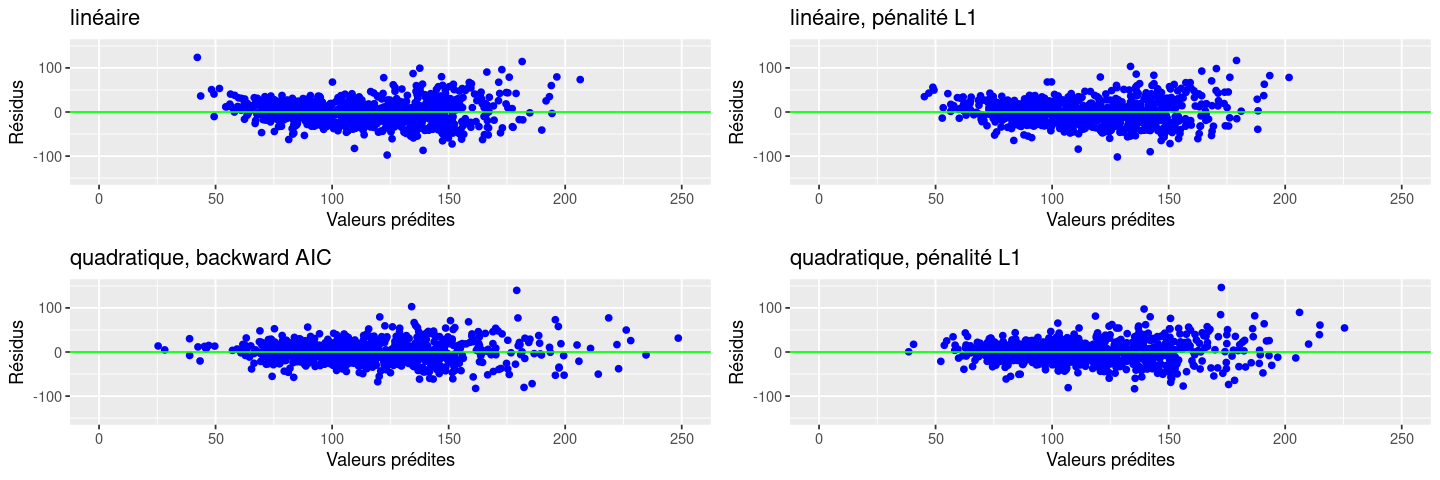

In [38]:
# Extraction of fitted values and residuals
fit.glm <- reg.glm.step$fitted.values
res.glm <- reg.glm.step$residuals
fit.lasso2 <- predict(reg.lasso2.cv, s = "lambda.min", newx = x.mat2)
res.lasso2 <- datappr$O3obs - fit.lasso2

# Graph of the residuals
g1<-gplot.res(fit.lm, res.lm, "linéaire")
g2<-gplot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")
g3<-gplot.res(fit.glm, res.glm, "quadratique, backward AIC")
g4<-gplot.res(fit.lasso2, res.lasso2, "quadratique, pénalité L1")
grid.arrange(g1,g2,g3,g4,ncol=2,nrow=2)

 We notice that the presence of some interactions or variables are relevant according to the Akaïke criterion but not significant according to the Fisher test. This presence in the model could be more finely analyzed by considering an estimate of the error by cross-validation. The idea would be to remove one by one the least significant variables or interactions to see how the cross-validation behaves. On the other hand, if the stepwise procedure leads to a different model, the estimation of the error by cross-validation also allows to optimize the choice.
 
These refinements are not efficient on these data. The model obtained by minimizing the AIC criterion is kept.


### Prediction of the test sample

The "optimal" model obtained by the backward  method is used to predict the test sample and thus to estimate, without bias, a prediction error. Two errors are estimated : the first one is the quadratic one for the regression while the second one is derived from the confusion matrix which crosses the predicted threshold overflows with those actually observed. 

#### Regression error

In [39]:
# Computation of forecasts for the quadratic backward model AIC
pred.glm <- predict(reg.glm.step, newdata = datestr)
# Mean squared error of prediction (MSE)
sum((pred.glm - datestr[, "O3obs"])^2) / nrow(datestr)

[1] 601.5874

In [40]:
# Quadratic error for MOCAGE
sum((datestr[,"MOCAGE"] - datestr[,"O3obs"])^2) / nrow(datestr)

[1] 1384.503

#### Classification error  (confusion matrix)

In [41]:
# Confusion matrix for threshold exceedance prediction
table(pred.glm > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   161   19
  TRUE      5   24

In [42]:
# Confusion matrix for the prediction of 
# threshold exceedance by MOCAGE
table(datestr[, "MOCAGE"] > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   141   19
  TRUE     25   24

Note these errors for comparison with those obtained by the other methods. Note the asymmetry of the errors.

## [Binomial Model Prediction](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)

Rather than predicting the concentration and then the exceedance, we can ask ourselves if it would not be relevant to directly predict the presence or absence of an exceedance. Since the variable to be modeled is binary, logistic regression will be used. As for regression, different model selection strategies can be used and compared before estimating the prediction error on the test sample.

### Logistic regression without interaction


In [43]:
# estimation of the complete model
log.lm <- glm(DepSeuil ~. , data = datappq, family = binomial)
# significance of the parameters
anova(log.lm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,737.8141,NA
JOUR,1,0.4443555,830,737.3698,5.050277e-01
MOCAGE,1,125.2166123,829,612.1532,4.563158e-29
TEMPE,1,136.8421803,828,475.3110,1.305601e-31
STATION,4,16.9891229,824,458.3219,1.942378e-03
VentMOD,1,11.7860664,823,446.5358,5.967570e-04
VentANG,1,0.8373860,822,445.6984,3.601454e-01
SRMH2O,1,6.4120067,821,439.2864,1.133512e-02
LNO2,1,0.1893011,820,439.0971,6.634989e-01


In [44]:
# Search for an optimal model in the sense of Akaïke
log.lm.step <- step(log.lm, direction = "backward")

Start:  AIC=459.72
DepSeuil ~ JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO

          Df Deviance    AIC
- MOCAGE   1   434.25 458.25
- JOUR     1   434.36 458.36
- VentANG  1   434.60 458.60
<none>         433.72 459.72
- LNO      1   439.10 463.10
- LNO2     1   439.21 463.21
- SRMH2O   1   440.49 464.49
- VentMOD  1   440.90 464.90
- STATION  4   455.47 473.47
- TEMPE    1   550.99 574.99

Step:  AIC=458.25
DepSeuil ~ JOUR + TEMPE + STATION + VentMOD + VentANG + SRMH2O + 
    LNO2 + LNO

          Df Deviance    AIC
- JOUR     1   434.79 456.79
- VentANG  1   435.23 457.23
<none>         434.25 458.25
- SRMH2O   1   441.49 463.49
- VentMOD  1   442.86 464.86
- LNO      1   447.00 469.00
- LNO2     1   451.13 473.13
- STATION  4   471.33 487.33
- TEMPE    1   558.59 580.59

Step:  AIC=456.79
DepSeuil ~ TEMPE + STATION + VentMOD + VentANG + SRMH2O + LNO2 + 
    LNO

          Df Deviance    AIC
- VentANG  1   436.01 456.01
<none>         434.79 456.79

In [45]:
# Obtained Model
anova(log.lm.step, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,737.8141,NA
TEMPE,1,214.189011,830,523.6251,1.674882e-48
STATION,4,32.315989,826,491.3091,1.648689e-06
VentMOD,1,29.015384,825,462.2937,7.180577e-08
SRMH2O,1,9.116772,824,453.1770,2.532764e-03
LNO2,1,5.017192,823,448.1598,2.509684e-02
LNO,1,12.150777,822,436.0090,4.906743e-04


In [46]:
# confusion matrix of the training sample and  training error
table(log.lm.step$fitted.values > 0.5, datappq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   673   70
  TRUE     24   65

### Logistic regression with interactions

With so many variables and interactions, and therefore parameters, the estimation of the complete logistic regression model encounters problems and displays *warnings* because some well-fitted probabilities (0 or 1) cause divisions by 0. Here a *forward* or better *stepwise* procedure for selecting the variables and interactions leads to reasonable results. A method with L1 penalization can also be used.

In [47]:

log.qm <- glm(DepSeuil ~ 1, data = datappq,family = binomial)
#  stepwise algorithm  
log.qm.step1 <- step(log.qm, direction = "both",
    scope = list(lower = ~1, upper = ~(JOUR + MOCAGE + TEMPE + 
            STATION + VentMOD + VentANG + LNO2 + LNO + SRMH2O)^2), 
    family=binomial)

Start:  AIC=739.81
DepSeuil ~ 1

          Df Deviance    AIC
+ TEMPE    1   523.63 527.63
+ MOCAGE   1   613.24 617.24
+ SRMH2O   1   683.87 687.87
+ VentANG  1   726.72 730.72
+ STATION  4   721.68 731.68
+ LNO2     1   727.76 731.76
+ VentMOD  1   733.38 737.38
<none>         737.81 739.81
+ LNO      1   736.47 740.47
+ JOUR     1   737.37 741.37

Step:  AIC=527.63
DepSeuil ~ TEMPE

          Df Deviance    AIC
+ MOCAGE   1   476.67 482.67
+ STATION  4   491.31 503.31
+ SRMH2O   1   503.12 509.12
+ VentMOD  1   515.31 521.31
+ VentANG  1   516.54 522.54
<none>         523.63 527.63
+ LNO      1   521.92 527.92
+ JOUR     1   522.78 528.78
+ LNO2     1   523.06 529.06
- TEMPE    1   737.81 739.81

Step:  AIC=482.67
DepSeuil ~ TEMPE + MOCAGE

               Df Deviance    AIC
+ SRMH2O        1   465.50 473.50
+ STATION       4   460.11 474.11
+ LNO           1   470.23 478.23
+ LNO2          1   471.61 479.61
+ VentMOD       1   473.42 481.42
+ VentANG       1   473.55 481.55
<none>  

In [48]:
anova(log.qm.step1, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,737.8141,NA
TEMPE,1,214.189011,830,523.6251,1.674882e-48
MOCAGE,1,46.956415,829,476.6687,7.258302e-12
SRMH2O,1,11.172483,828,465.4962,8.301945e-04
STATION,4,15.922320,824,449.5739,3.125190e-03
VentMOD,1,8.683311,823,440.8906,3.211370e-03
TEMPE:STATION,4,11.682335,819,429.2083,1.987666e-02
MOCAGE:VentMOD,1,5.702069,818,423.5062,1.694493e-02
SRMH2O:STATION,4,15.218744,814,408.2874,4.268380e-03


### Prediction of the test sample

#### Confusion matrix

In [49]:
# Prediction by the quadratic model
pred.log <- predict(log.qm.step1, newdata = datestq, type = "response")
# Confusion matrix
table(pred.log > 0.5, datestq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   164   20
  TRUE      2   23

Compare with the previous approach. Save the results for comparison with other methods.

####  ROC curve

It is also possible to construct a ROC curve in association with the prediction obtained from a Gaussian linear model. Indeed, the variation of the theoretical threshold of overtaking (150) will vary the respective proportions of the true and false positive rates. This is the same as varying the threshold of a "proba" for the forecast values divided by 300.


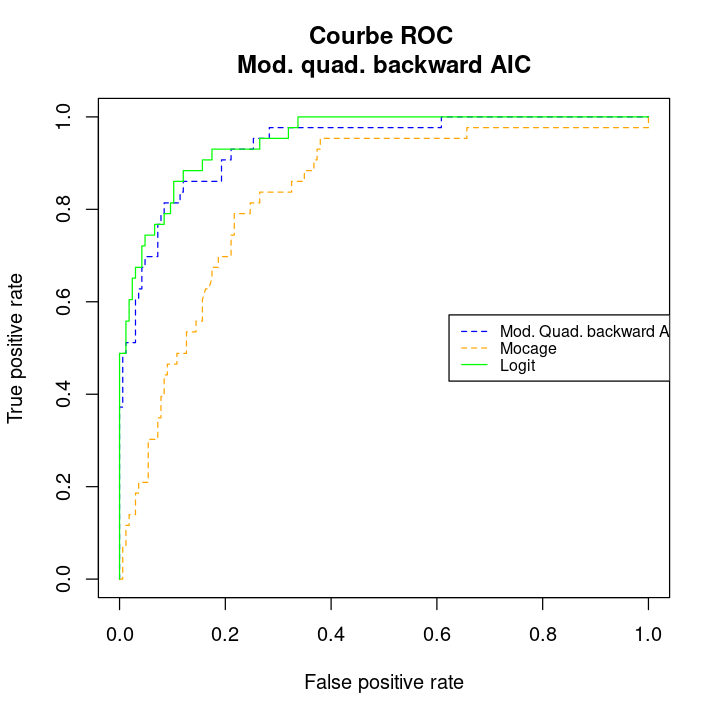

In [50]:
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
rocmocage <- datestr[,  "MOCAGE"] / 300 
DepSeuil=c(datestr[, "O3obs"] > 150)
predmocage <- prediction(rocmocage,DepSeuil)
perfmocage <- performance(predmocage, "tpr", "fpr")


rocglm <- pred.glm / 300    
predglm <- prediction(rocglm,DepSeuil)
perfglm <- performance(predglm, "tpr", "fpr")

roclogit <- predict(log.qm.step1, newdata = datestq, type="response")
predlogit <- prediction(roclogit, datestq[, "DepSeuil"])
perflogit <- performance(predlogit, "tpr", "fpr")

plot(perfglm, col = "blue",lty=2, main = "Courbe ROC \n Mod. quad. backward AIC ")
plot(perfmocage,col="orange",lty=2,add=TRUE)
plot(perflogit,col="green",lty=1,add=TRUE) 

legend("right", legend=c("Mod. Quad. backward AIC", "Mocage", "Logit"),
       col=c("blue","orange","green"), lty=c(2,2,1), text.font=1,    cex=0.8)


**Question** What are sensitivity and specificity of a ROC curve?

The results obtained obviously depend in addition on the initial sampling between training and test. In the case where the curves cross, it means that there is no uniformly better prediction of the occurrence of treshold overflow. This depends on the sensitivity or specificity chosen for the model. This underlines the importance of the correct definition of the criterion to be used for the choice of a "best" method. This choice depends directly on the "political" or "economic" choice of sensitivity and/or specificity of the chosen model. In other words, what false alarm rate, with obvious economic implications, is bearable with respect to the undetected exceedances and thus the health degradation of the population at risk?
 
Once this choice has been made, the statistician can make a comparison of the methods involved.

**Question** Are the performances of the two Gaussian and binomial approaches very different?

**Question** On the graph above, add the ROC curve for the deterministic MOCAGE model. What do you observe?


# <FONT COLOR="Red">Episode 2 : Discriminant Analysis, KNN, SVM </font>

## [Discriminant Analysis](http://wikistat.fr/pdf/st-m-app-add.pdf)

### Introduction

 The objective is to compare the three discriminant analysis methods available in R: linear parametric `lda` (homoscedasticity), quadratic parametric `qda` (heteroscedasticity) under Gaussian assumption and non-parametric $K$ nearest neighbors.
 
**Question** Which assignment criterion is used in LDA?

**Question** What do the homoscedasticity or heteroscedasticity assumptions mean?

**Question** Which function is estimated "non-parametrically" by the $K$ nearest neighbors algorithm?
 
*Note*: these techniques only accept quantitative explanatory or predictive variables. Nevertheless, a qualitative variable with two modalities, for example the type of day, can be considered as quantitative in the form of an indicator function taking its values in $\{0, 1\}$. In this last case, one should not try to interpret the discrimination functions, just consider prediction errors. The *Station* variable is not taken into account.

The standard R library `MASS` for discriminant analysis does not propose an automatic procedure for choosing a variable, but in this example, the variables are few.


### Estimation of the models

In [55]:
library(MASS) # 
library(class) #  for KNN

In [56]:
# linear discriminant analysis
disc.lda=lda(DepSeuil~.,data=datappq[,-4]) 
# quadratic discriminant analysis
disc.qda=qda(DepSeuil~.,data=datappq[,-4]) 
# k nearest neighbours
disc.knn=knn(datappq[,c(-4,-10)],datappq[,c(-4,-10)],datappq$DepSeuil,k=10) 

Note the lack of homogeneity of R commands from different libraries. The negative column index ($-10$) allows to remove the column containing the variable to be predicted of type factor. This one is mentioned in the third parameter for the training data. The [caret library](http://topepo.github.io/caret/index.html) circumvents these difficulties by encompassing all the training libraries and homogenizing the calls for model estimation and prediction. 

In [58]:
install.packages("caret")

Installation du package dans ‘/home/mbui/R/libs’
(car ‘lib’ n'est pas spécifié)

installation de la dépendance ‘ModelMetrics’




In [60]:
library(caret)
lda.fit<-train(DepSeuil~.,data=datappq[,-4],method="lda")
qda.fit<-train(DepSeuil~.,data=datappq[,-4],method="qda")
knn.fit<-train(DepSeuil~.,data=datappq[,-4],method="knn")

### Estimation of the prediction error by cross-validation 

#### Without the use of the `caret` library

In [61]:
# cross-validation error for linear discriminant analysis
disc.lda=lda(DepSeuil~.,data=datappq[,-4],CV=T) 
# estimate the error rate from the confusion matrix
table(datappq[,"DepSeuil"],disc.lda$class)  

       
        FALSE TRUE
  FALSE   673   24
  TRUE     77   58

In [62]:
#  quadratic discriminant analysis
disc.qda=qda(DepSeuil~.,data=datappq[,-4],CV=T)  
table(datappq[,"DepSeuil"],disc.qda$class) 

       
        FALSE TRUE
  FALSE   665   32
  TRUE     78   57

For Knn, the choice of the number of neighbors $K$ has to be optimized by cross-validation but the procedure proposed by the `class` library is the *leave-one-out* one, so it is too computationally expensive for large files. It would be easy to program it but the `e1071` library already proposes several cross-validation functions for many discrimination techniques. 


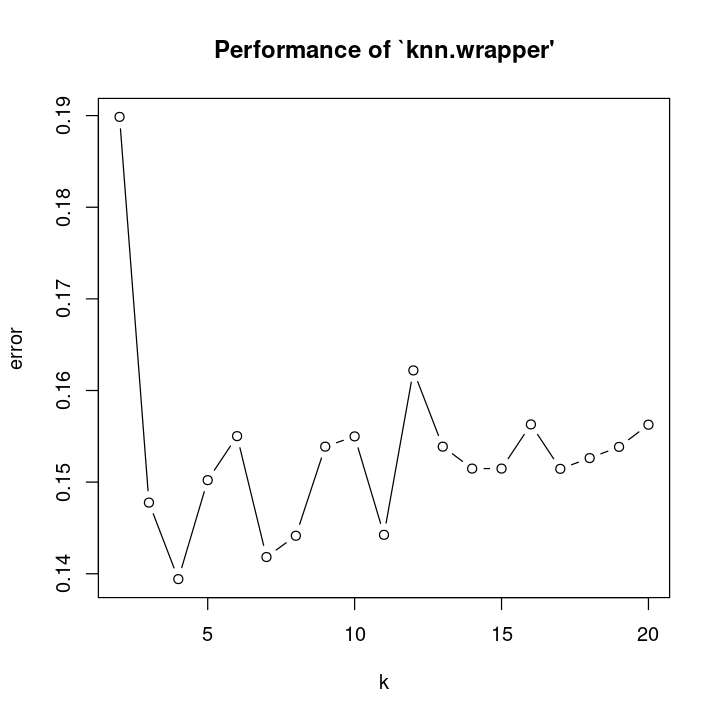

In [63]:
# optimisation of  the number of neighbours in KNN
library(e1071)
plot(tune.knn(as.matrix(datappq[,c(-4,-10)]),as.factor(datappq[,10]),k=2:20))

**Question** Which cross-validation procedure is executed by default by the `tune()` function?

**Question** Run several successive executions of this "optimization". Why does the value of $K$ differ at each run? How to choose $K$ ?

**Question** Compare with the previous errors estimated also by cross-validation. Which discriminant analysis should be used? Why ?


#### With the  `caret` library

In [64]:
# Cross-validation with 10 folds
param_train<-trainControl(method="cv",number=10)
# cross-validation error for linear discriminant analysis
lda.fit <- train(DepSeuil~.,data=datappq[,-4],method="lda",trControl=param_train)
#  estimate the error rate from the confusion matrix
table(datappq[,"DepSeuil"],predict(lda.fit,datappq[,-c(4,10)])) 

       
        FALSE TRUE
  FALSE   674   23
  TRUE     77   58

In [65]:
# cross-validation error for quadratic discriminant analysis
qda.fit <- train(DepSeuil~.,data=datappq[,-4],method="qda",trControl=param_train)
# estimate the error rate from the confusion matrix
table(datappq[,"DepSeuil"],predict(qda.fit,datappq[,-c(4,10)])) 

       
        FALSE TRUE
  FALSE   668   29
  TRUE     73   62

In [66]:
#cross-validation error for kNN
knn.fit <- train(DepSeuil~.,data=datappq[,-4],method="knn",trControl=param_train,tuneLength=20)
#  estimate the error rate from the confusion matrix
table(datappq[,"DepSeuil"],predict(knn.fit,datappq[,-c(4,10)])) 

       
        FALSE TRUE
  FALSE   677   20
  TRUE     59   76

### Prediction of the test sample

#### Confusion matrices

The following commands calculate the confusion matrix on the test dataset for each cross-validation optimized discriminant analysis method. 


In [67]:
## LDA
table(predict(lda.fit,datestq[,-4]),datestq[,"DepSeuil"])
sum(predict(lda.fit,datestq[,-4])!=datestq[,"DepSeuil"])/nrow(datestq)

       
        FALSE TRUE
  FALSE   162   21
  TRUE      4   22

[1] 0.1196172

In [68]:
## QDA
table(predict(qda.fit,datestq[,-4]),datestq[,"DepSeuil"])
sum(predict(qda.fit,datestq[,-4])!=datestq[,"DepSeuil"])/nrow(datestq)

       
        FALSE TRUE
  FALSE   160   26
  TRUE      6   17

[1] 0.15311

In [69]:
##  KNN
table(predict(knn.fit,datestq[,-4]),datestq[,"DepSeuil"])
sum(predict(knn.fit,datestq[,-4])!=datestq[,"DepSeuil"])/nrow(datestq)

       
        FALSE TRUE
  FALSE   161   23
  TRUE      5   20

[1] 0.1339713

One can also use the function `confusionMatrix()` :

In [70]:
help(confusionMatrix)

confusionMatrix {ModelMetrics},R Documentation
actual,A vector of the labels
predicted,A vector of predicted values
cutoff,A cutoff for the predicted values


In [71]:
confusionMatrix(predict(knn.fit,datestq[,-4]),datestq[,"DepSeuil"],positive="TRUE")

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   161   23
     TRUE      5   20
                                          
               Accuracy : 0.866           
                 95% CI : (0.8122, 0.9091)
    No Information Rate : 0.7943          
    P-Value [Acc > NIR] : 0.004849        
                                          
                  Kappa : 0.5148          
                                          
 Mcnemar's Test P-Value : 0.001315        
                                          
            Sensitivity : 0.46512         
            Specificity : 0.96988         
         Pos Pred Value : 0.80000         
         Neg Pred Value : 0.87500         
             Prevalence : 0.20574         
         Detection Rate : 0.09569         
   Detection Prevalence : 0.11962         
      Balanced Accuracy : 0.71750         
                                          
       'Positive' Class : TRUE            
                     

#### ROC curves

Here we will compare via the ROC curve the discriminant analysis methods LDA, QDA, KNN and logistic regression (see Episode 1) 

In [72]:
# Logistic regression from Episode 1 
log.qm <- glm(DepSeuil ~ 1, data = datappq,family = binomial)
log.qm.step1 <- step(log.qm, direction = "both",
    scope = list(lower = ~1, upper = ~(JOUR + MOCAGE + TEMPE + 
            STATION + VentMOD + VentANG + LNO2 + LNO + SRMH2O)^2), 
    family=binomial,trace=0)

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



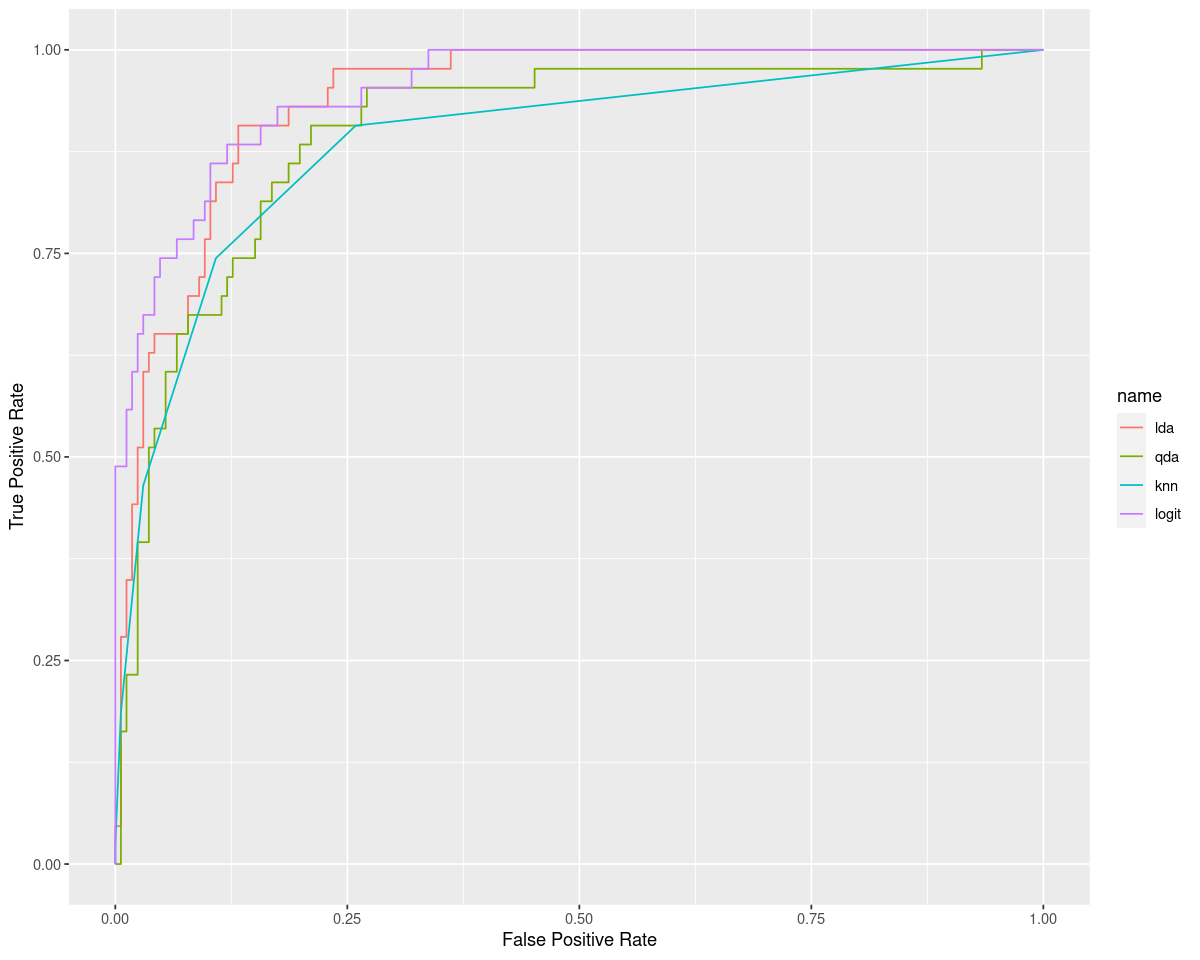

In [73]:
library(pROC)
rocobjlda<-roc(datestq$DepSeuil,predict(lda.fit,datestq[,-4],type="prob")[,2])
rocobjqda<-roc(datestq$DepSeuil,predict(qda.fit,datestq[,-4],type="prob")[,2])
rocobjknn<-roc(datestq$DepSeuil,predict(knn.fit,datestq[,-4],type="prob")[,2])
rocobjlogit<-roc(datestq[, "DepSeuil"],predict(log.qm.step1, newdata = datestq, type="response"))

options(repr.plot.width = 10, repr.plot.height = 8)
ggroc(list(lda=rocobjlda,qda=rocobjqda,knn=rocobjknn,logit=rocobjlogit),legacy.axes=T)+
  xlab("False Positive Rate")+
  ylab("True Positive Rate")

**Question** Is a method uniformly better on this test sample?

## [Support Vector Machine (SVM)](http://wikistat.fr/pdf/st-m-app-svm.pdf)


### Introduction
Despite the theoretical guarantees concerning this type of algorithm, the results depend strongly on the choice of parameters. We will first limit ourselves to the Gaussian kernel (default choice); the function `tune.svm` allows to easily test several situations by estimating the prediction quality by cross-validation on a grid. The execution time in R is a bit long... 

**Question** Is the execution time for SVM more sensitive to the number of observations or to the number of variables? Why?

### Regression
Although initially developed in the case of a binary variable, SVMs have been extended to regression problems. The estimation and optimization of the penalty coefficient are obtained by the following commands.  

In [74]:
library(e1071)
help(svm)

svm {e1071},R Documentation
formula,a symbolic description of the model to be fit.
data,an optional data frame containing the variables in the model. By default the variables are taken from the environment which ‘svm’ is called from.
x,"a data matrix, a vector, or a sparse matrix (object of class Matrix provided by the Matrix package, or of class matrix.csr provided by the SparseM package, or of class simple_triplet_matrix provided by the slam package)."
y,a response vector with one label for each row/component of x. Can be either a factor (for classification tasks) or a numeric vector (for regression).
scale,"A logical vector indicating the variables to be scaled. If scale is of length 1, the value is recycled as many times as needed. Per default, data are scaled internally (both x and y variables) to zero mean and unit variance. The center and scale values are returned and used for later predictions."
type,"svm can be used as a classification machine, as a regression machine, or for novelty detection. Depending of whether y is a factor or not, the default setting for type is C-classification or eps-regression, respectively, but may be overwritten by setting an explicit value. Valid options are: C-classification nu-classification one-classification (for novelty detection) eps-regression nu-regression"
kernel,"the kernel used in training and predicting. You might consider changing some of the following parameters, depending on the kernel type. linear:u'v polynomial:(\gamma u'v + coef0)^{degree} radial basis:e^(-\gamma |u-v|^2) sigmoid:tanh(\gamma u'v + coef0)"
degree,parameter needed for kernel of type polynomial (default: 3)
gamma,parameter needed for all kernels except linear (default: 1/(data dimension))
coef0,parameter needed for kernels of type polynomial and sigmoid (default: 0)


In [75]:
svm.reg0 = svm(O3obs ~ ., data = datappr)
summary(svm.reg0)


Call:
svm(formula = O3obs ~ ., data = datappr)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.07692308 
    epsilon:  0.1 


Number of Support Vectors:  711






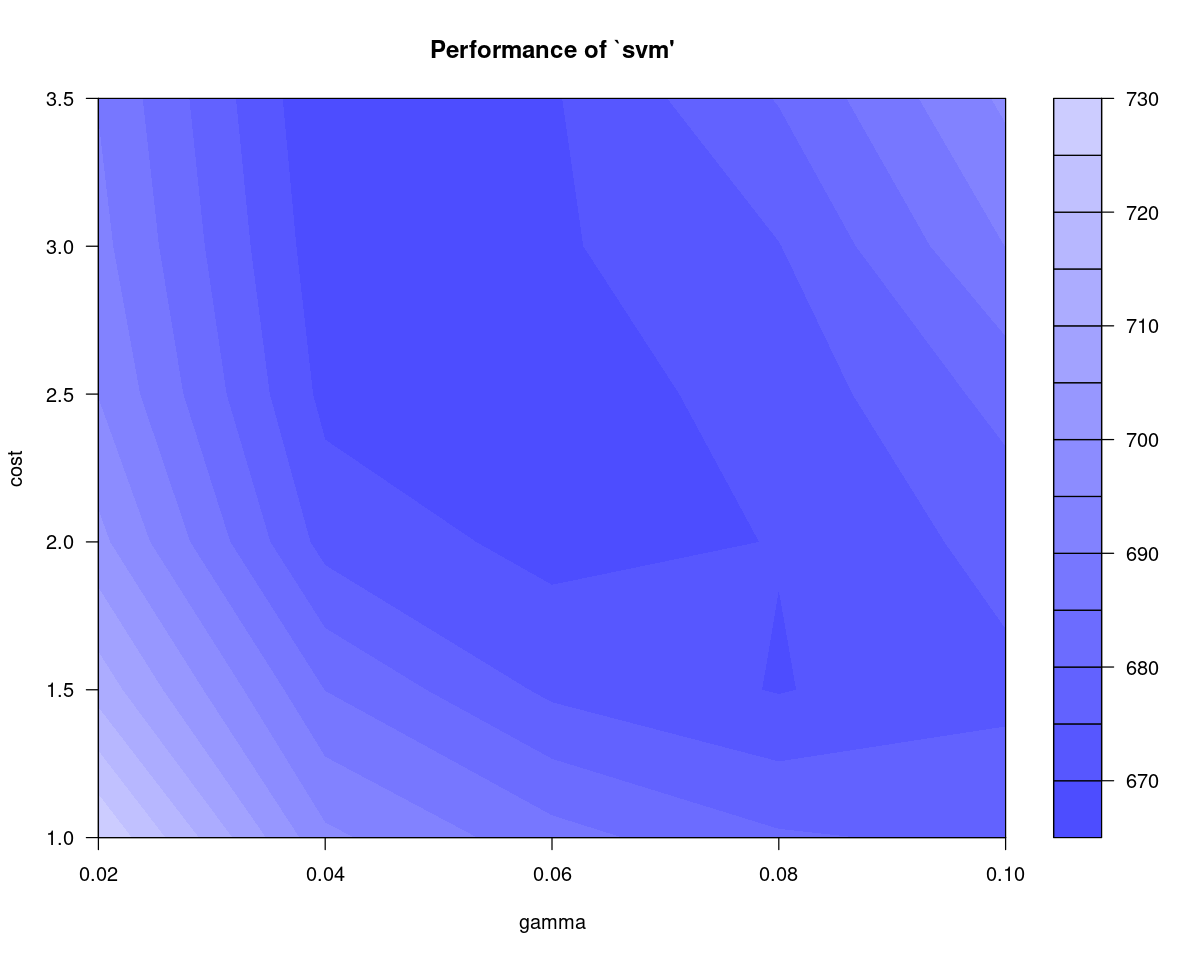

In [76]:
#set.seed(2021)
svm.reg.tune = tune.svm(O3obs ~ ., data = datappr, cost = c(1, 1.5, 2, 2.5, 3, 3.5), 
    gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.reg.tune)

By default the penalty (cost) is 1.

**Question** Note the optimal penalty for the considered kernel (Gaussian). Re-estimate the supposedly optimal model before plotting the residuals. As before, observe that several runs lead to different results and thus that the optimization of this parameter is tricky to say the least.

**Question** What other kernels are available in this implementation of SVM?

In [77]:
svm.reg = svm(O3obs ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)
summary(svm.reg)


Call:
svm(formula = O3obs ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  3.5 
      gamma:  0.04 
    epsilon:  0.1 


Number of Support Vectors:  709






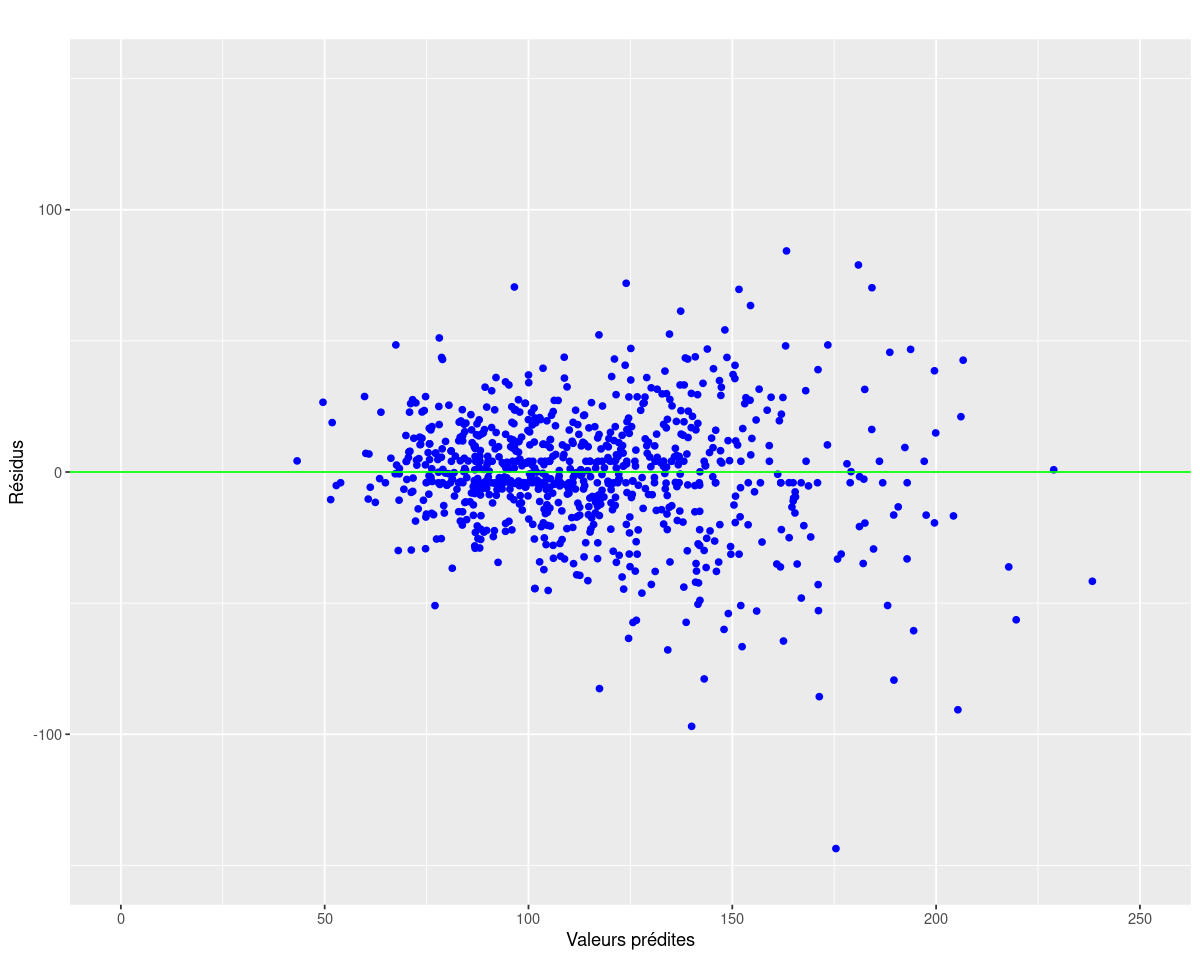

In [78]:
# computation and graph of the residuals
fit.svmr=fit.svmr=svm.reg$fitted
res.svmr=fit.svmr-datappr[,"O3obs"]
gplot.res(fit.svmr,res.svmr,titre="")

Observe the "corridor" effect on the residuals. 

**Question** What causes the residuals to move closer together in a "corridor"? What do you observe when you vary the cost and epsilon parameters?

### Discrimination

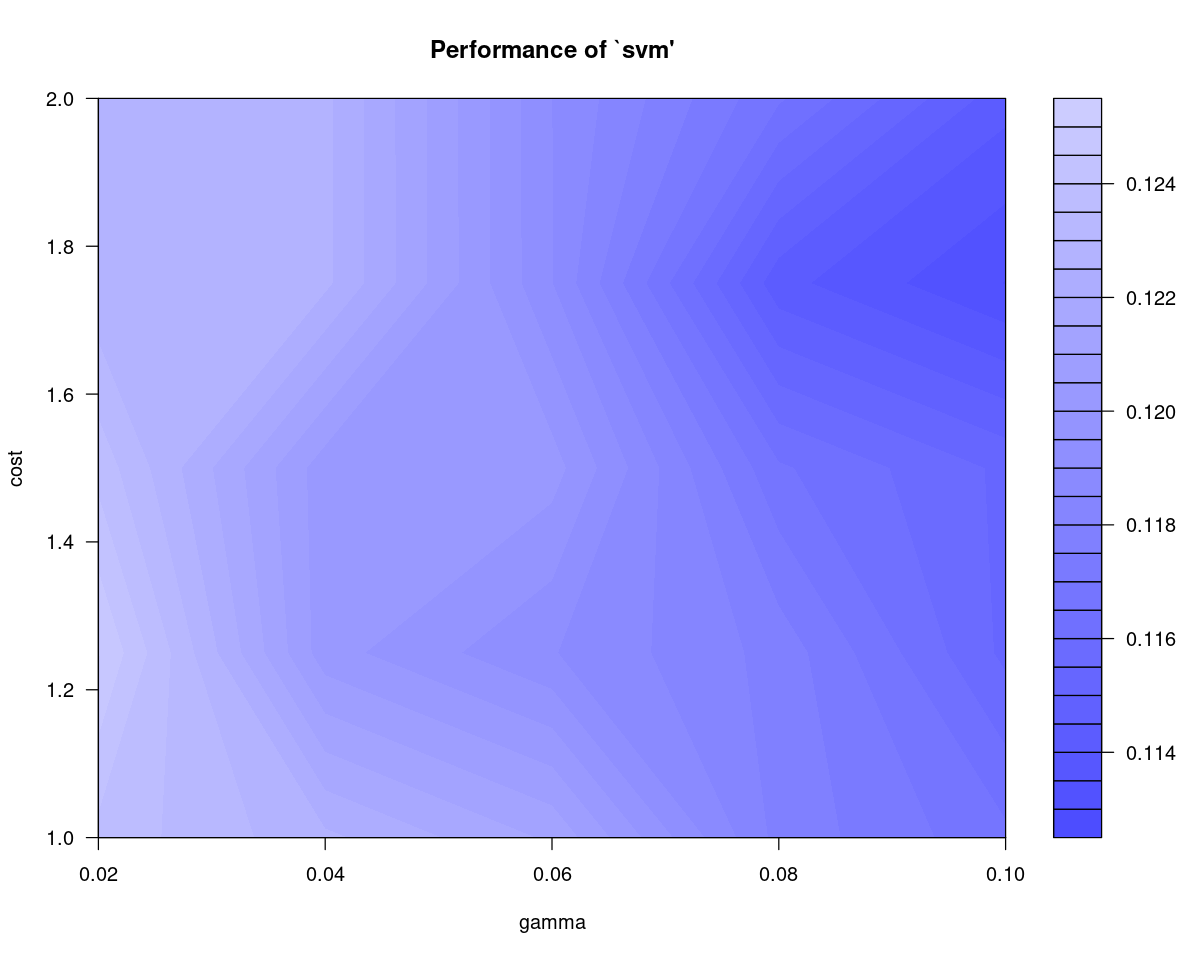

In [79]:
# optimisation
svm.dis.tune = tune.svm(DepSeuil ~ ., data = datappq, cost = c(1,1.25,1.5,1.75,2), 
    gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.dis.tune)

In [80]:
# training
svm.dis.tune$best.parameters
svm.dis=svm(DepSeuil~.,data=datappq,cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)

,gamma,cost
,<dbl>,<dbl>
20,0.1,1.75


### Prediction on the test sample
#### Regression error

In [81]:
pred.svmr=predict(svm.reg,newdata=datestr)
# Mean squared error of prediction
sum((pred.svmr-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 538.0744

####  Classification error (confusion matrices)

In [82]:
# Confusion matrix for prediction of threshold overflow (regression)
table(pred.svmr>150,datestr[,"O3obs"]>150)

       
        FALSE TRUE
  FALSE   163   17
  TRUE      3   26

In [83]:
# Same thing for discrimination
pred.svmq=predict(svm.dis,newdata=datestq)
table(pred.svmq,datestq[,"DepSeuil"])

         
pred.svmq FALSE TRUE
    FALSE   165   23
    TRUE      1   20

#### ROC curves

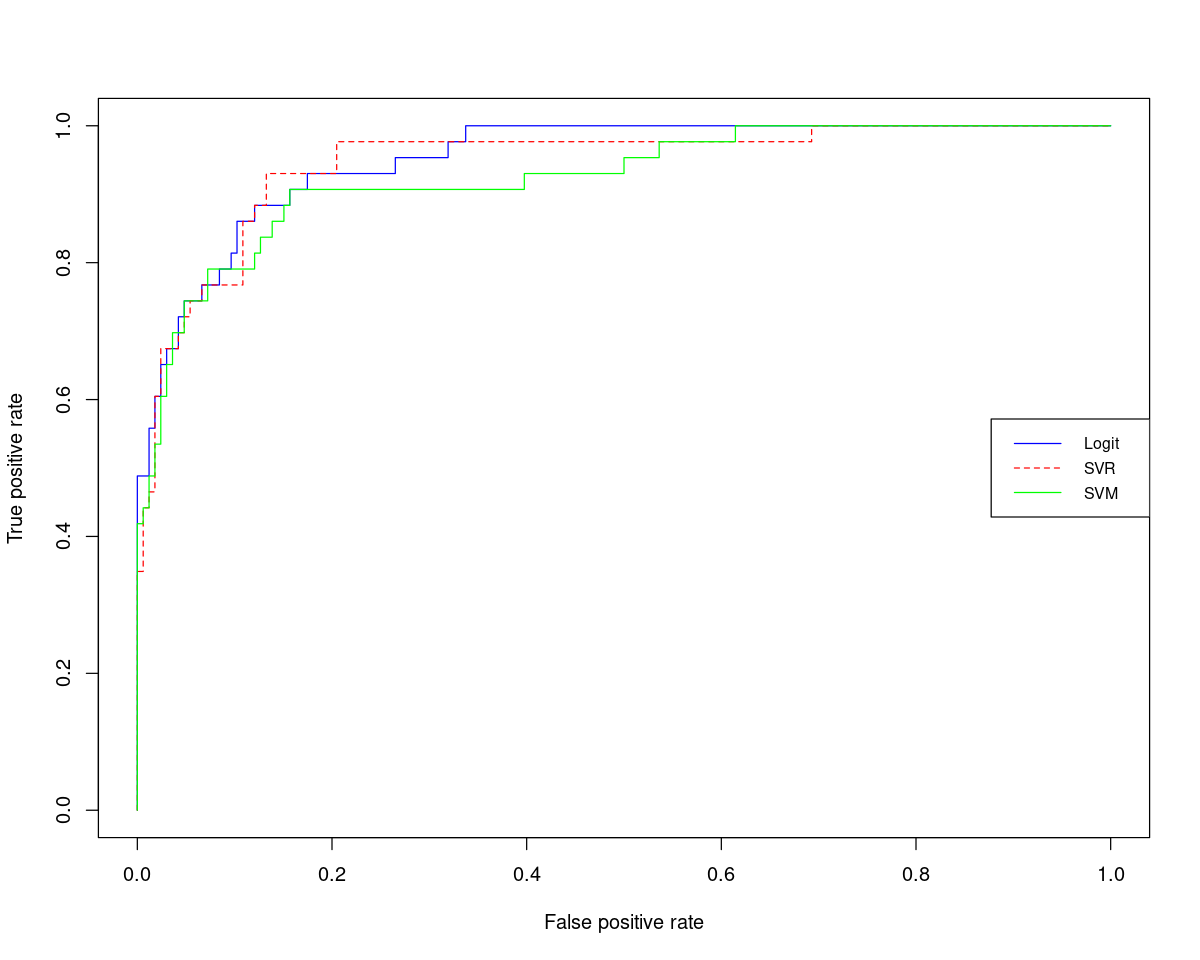

In [84]:
rocsvmr = pred.svmr/300
predsvmr = prediction(rocsvmr, datestq$DepSeuil)
perfsvmr = performance(predsvmr, "tpr", "fpr")

# re-estimate the model to obtain the probabilities 
svm.dis = svm(DepSeuil ~ ., data = datappq, cost = 1.25, probability = TRUE)
pred.svmq = predict(svm.dis, newdata = datestq, probability = TRUE)
rocsvmq = attributes(pred.svmq)$probabilities[, 2]
predsvmq = prediction(rocsvmq, datestq$DepSeuil)
perfsvmq = performance(predsvmq, "tpr", "fpr")

plot(perflogit, col = "blue")
plot(perfsvmr, col = "red", lty = 2, add = TRUE)
plot(perfsvmq, col = "green", add = TRUE)


legend("right", legend=c("Logit","SVR", "SVM"),
       col=c("blue","red","green"), lty=c(1,2,1), text.font=1,    cex=0.8)

**Question** Do SVMs bring an improvement?

# <FONT COLOR="Red">Episode 3 :  CART, Agreggation of models  </font>

## [Binary decision tree](http://wikistat.fr/pdf/st-m-app-cart.pdf)

The `rpart` library is the most commonly used for the construction of decision trees. Two types of trees can be estimated depending on whether the variable to be modeled is the ozone concentration (regression tree) or directly the threshold overflow (discrimination or decision tree). Different parameters control the execution of the algorithm: the minimum penalty (cp) for the construction of the maximum tree, the minimum number of observations per node, the number of cross-validations (by default 10)... see the online help (`?rpart.control`) for more details but it is not very explicit on some parameters.

NB. A sequence of values of the `cp` penalty is associated to a sequence of nested trees.

### Estimation and pruning of the regression tree
**Question** Which criterion is optimized when creating a node in the tree?


In [ ]:
library(rpart) 
help(rpart)
help(rpart.control)

In [ ]:
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=0.001))

The command `summary(tree.reg)` provides a description of the resulting tree but a graph is preferable.

In [ ]:
library(rpart.plot)
options(repr.plot.width = 15, repr.plot.height = 10)
rpart.plot(tree.reg)

The tree is unreadable and has too many leaves for a good prediction (overlearning), it is necessary to reduce the number by pruning. The following commands compute the predictions obtained by 10-fold cross-validation for each pruned tree according to the successive values of the complexity coefficient. The sequence of these values is implicitly the one provided by `rpart`.

In [ ]:
help(xpred.rpart)
xmat<-xpred.rpart(tree.reg,xval=10) 
# one row for each observation and one column for each complexity value

# Cross-validation error by CP value
CVerr<-apply((xmat-datappr[,"O3obs"])^2,2,sum)

plotcp(tree.reg)

Find the value of `cp` corresponding to the smallest error and use it to build the tree.

In [ ]:
as.numeric(attributes(which.min(CVerr))$names)
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))
rpart.plot(tree.reg,type=5,extra=101)

The `partykit` library proposes a graphical construction of the tree : 

In [ ]:
library(partykit)
plot(as.party(tree.reg), type="simple")

The window is too small to show the distributions (histogram) of the target variable (ozone concentration) in each sheet. 

**Question** Which variable contributes the most to the interpretation?

Residuals plot


In [ ]:
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"O3obs"]
gplot.res(fit.tree,res.tree,"residus de tree.reg")

**Question** To what is due the particular structure of this graph ?

Here is an example of code to do this pruning with the `caret` library

In [ ]:
ctrl <- trainControl(method = "cv",number = 10)
treecaret <- train(O3obs~.,data=datappr,method = "rpart",trControl = ctrl,tuneLength =20)
print(paste("Valeur de cp retenue = ",treecaret$bestTune,sep=""))
rpart.plot(treecaret$finalModel)

### Estimation and pruning of a discrimination tree

In the case of discrimination, the default criterion is the Gini concentration index; it is possible to specify another criterion (split="information") as well as weights on the observations, a misclassification cost matrix and a priori probabilities (`?rpart` for more details).

**Question** What other heterogeneity criterion is used?

In [ ]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),cp=0.001)
rpart.plot(tree.dis) 

The same cross-validation pruning procedure is implemented but with a different expression of the prediction error : misclassification rate rather than squared error.

In [ ]:
xmat = xpred.rpart(tree.dis)
# Comparison of predicted and observed values
xerr=datappq$DepSeuil!= (xmat>1.5) 
# Estimation of the error rate
CVerr=apply(xerr, 2, sum)/nrow(xerr)
CVerr

In [ ]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),cp=as.numeric(attributes(which.min(CVerr))$names))
rpart.plot(tree.dis,type=4)

With the `caret` library :

In [ ]:
ctrl <- trainControl(method = "cv",number = 10)
treecaret <- train(DepSeuil~.,data=datappq,method = "rpart",trControl = ctrl,tuneLength =20,metric="Accuracy")
print(paste("Valeur de cp retenue = ",treecaret$bestTune,sep=""))
rpart.plot(treecaret$finalModel)

### Prediction of the test sample

Different predictions are considered along with the estimated errors on the test sample. Quantitative concentration prediction, exceedance prediction from the quantitative prediction and directly the exceedance prediction from the decision tree.

#### Regression error

In [ ]:
# Computation of the predictions
pred.treer=predict(tree.reg,newdata=datestr)
# Mean squared error in regression
sum((pred.treer-datestr[,"O3obs"])^2)/nrow(datestr)

#### Classification error (confusion matrix)

In [ ]:
# Confusion matrix for the prediction of 
# threshold overflow (regression)
  #table(pred.treer>150,datestr[, "O3obs"]>150)
confusionMatrix(as.factor(pred.treer>150),as.factor(datestr[,"O3obs"]>150))$table

In [ ]:
# Same thing for the discrimination tree
pred.treeq=predict(tree.dis,newdata=datestq,type="class")
  #table(pred.treeq,datestq[,"DepSeuil"])
confusionMatrix(pred.treeq,datestq[,"DepSeuil"])$table

**Question** Which strategy seems better at this level?

#### ROC curves

In [ ]:

ROCregtree=pred.treer/300
predregtree=prediction(ROCregtree,datestq$DepSeuil)
perfregtree=performance(predregtree,"tpr","fpr")
ROCdistree=predict(tree.dis,newdata=datestq,type="prob")[,2]
preddistree=prediction(ROCdistree,datestq$DepSeuil)
perfdistree=performance(preddistree,"tpr","fpr")
# tracer les courbes ROC en les superposant 
# pour mieux comparer

options(repr.plot.width = 8, repr.plot.height = 6)
plot(perflogit,col="blue")
plot(perfregtree,col="orange",lty=2,add=TRUE) 
plot(perfdistree,col="green",add=TRUE)  

legend("right", legend=c("Logit", "TreeReg", "TreeDis"),
       col=c("blue","orange","green"), lty=c(1,2,1), text.font=1,    cex=0.8)


**Question** Compare the predictive qualities. Does a better method emerge?

## [Model Aggregation ](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

### Introduction
The previous sections have allowed us to experiment with the construction of a forecasting model with the recurrent problem of optimizing the complexity of a model. This section discusses other strategies whose objective is to get rid of this problem of choice by methods that are not very sensitive to overlearning; this is the case of model aggregation algorithms.

This section proposes to highlight the greater or lesser influence of the parameters of these methods.

*Random forest* : number of trees and `mtry` and interest of Breiman criteria allowing to measure the influence of variables within an aggregated family of models. 

*Boosting*: tree depth, number of iterations or trees and *shrinkage* coefficient.



### Random forests
The program is available in the `randomForest` library. It is written in fortran, so in principle it is efficient in terms of speed of execution, and easy to use thanks to an interface with R. The comparison with Python shows that it is not very efficient, probably because of the interface with R. The parameters and outputs are explained in the online help.

In R and for large files, use the `ranger` library instead of `randomForest`.

**Question** What is the `mtry` parameter of the `randomForest` function?

**Question** How is bagging a special case of random forests?

Bagging will not be treated in this tutorial.


In [ ]:
library(randomForest)
help(randomForest)

#### Regression

In [ ]:

rf.reg=randomForest(O3obs~., data=datappr,xtest=datestr[,-2],ytest=datestr[,"O3obs"],
   ntree=500,do.trace=50,importance=TRUE)
attributes(rf.reg)
rf.reg$mtry

**Question** What is the default value of `mtry`?

Rerun by varying the parameters `mtry` and `ntree` to experiment their little influence on the errors.

Compute and plot the residuals.

In [ ]:
fit.rfr=rf.reg$predicted
res.rfr=fit.rfr-datappr[,"O3obs"]
gplot.res(fit.rfr,res.rfr,titre="")

#### Discrimination
**Question** What is the default value of `mtry`?

In [ ]:
rf.dis=randomForest(DepSeuil~.,data=datappq,xtest=datestq[,-10],ytest=datestq[,
   "DepSeuil"],ntree=500,do.trace=50,importance=TRUE)
rf.dis$importance

In [ ]:
rf.dis$mtry

**Question** Comment on the errors, test other runs with other parameter values.

### Variable Importance 
The resulting model is uninterpretable, but coefficients estimate the contributions of the variables in their participation in discrimination. Compare with the variables selected by the other models in episode 1. Two importance criteria are proposed.

**Question** What are the two measures of importance of the variables?

In [ ]:
sort(round(importance(rf.reg), 2)[,1], decreasing=TRUE)
sort(round(importance(rf.dis), 2)[,4], decreasing=TRUE)

In [ ]:
varImpPlot(rf.reg)

In [ ]:
varImpPlot(rf.dis)

In [ ]:
library(ggRandomForests)
plot(gg_vimp(rf.reg))
plot(gg_vimp(rf.dis))

### Prediction of the test sample
#### Regression

In [ ]:
# Random forests
pred.rfr=rf.reg$test$predicted
# Mean squared error
sum((pred.rfr-datestr[,"O3obs"])^2)/nrow(datestr)

In [ ]:
# Confusion matrix for the prediction of the threshold overflow (regression)
table(pred.rfr>150,datestr[,"O3obs"]>150)

#### Classification

In [ ]:
pred.rfq=rf.dis$test$predicted
table(pred.rfq,datestq[,"DepSeuil"])
confusionMatrix(pred.rfq,datestq[,"DepSeuil"],positive="TRUE")

**Question** What does the comparison of the ROC curves indicate ?

### Boosting
Two libraries offer relatively sophisticated versions of *boosting* algorithms in R. The *boost* library offers 4 approaches: *adaboost, bagboost* and two *logitboost*. Developed for a particular problem: the analysis of genomic expression data, it may not be completely adapted to the data studied; it is limited to quantitative predictors and may provide strange results. The *gbm* library is preferred; it also offers several versions depending on the chosen cost function. A more recent library `xgboost` integrates parallelization features (not under Windows) and uses several other parameters.

The variable to predict must be numerically coded (0-1) for this implementation. The number of iterations, or number of trees, is set as well as a shrinkage coefficient (*shrinkage*).

**Question** How does *shrinkage* come into play in *boosting*? 

**Question** For which boosting? Or what does `gbm` mean?

*Warning*, by default, this parameter has a very low value (0.001) and it takes a large number of iterations (of trees) to reach a reasonable estimate. The quality is visualized by a graph representing the evolution of the learning error. On the other hand, a cross-validation procedure is incorporated in order to optimize the number of trees because the version of *boosting* considered is (slightly) prone to over-learning.

#### Regression

In [ ]:
class(ozone$STATION)

In [ ]:
library(gbm)
boost.reg = gbm(O3obs ~ ., data = datappr, distribution = "gaussian", n.trees = 500, 
    cv.folds = 10, n.minobsinnode = 5, shrinkage = 0.03, verbose = FALSE)
# set verbose to FALSE to avoid too many outputs
plot(boost.reg$cv.error, type = "l")

In [ ]:
# Optimal number of iterations by cross-validation
best.iter=gbm.perf(boost.reg,method="cv")

We can ensure the absence of a critical overfitting phenomenon by calculating and plotting the evolution of the error on the test sample as a function of the number of trees in the model. The error remains stable around the number of trees selected and shown by the vertical line. 

**Question** Test these functions by varying the shrinkage coefficient.


In [ ]:
test=numeric()
for (i in 10:500){
pred.test=predict(boost.reg,newdata=datestr,n.trees=i)
err=sum((pred.test-datestr[,"O3obs"])^2)/nrow(datestr)
test=c(test,err)}
plot(10:500,test,type="l")
abline(v=best.iter)

#### Discrimination
Be careful, the variable to model must be coded $(0, 1)$ and another distribution parameter must be specified to consider the right error term.

In [ ]:
datappq2=datappq
datappq2[,"DepSeuil"]=as.numeric(datappq[,"DepSeuil"])-1
boost.dis=gbm(DepSeuil~.,data=datappq2,distribution="adaboost",n.trees=500, cv.folds=10,
              n.minobsinnode = 5,shrinkage=0.03,verbose=FALSE)
plot(boost.dis$cv.error,type="l")

In [ ]:
# optimal number of iterations
best.ited=gbm.perf(boost.dis,method="cv")

As for the regression, it is possible to vary the shrinkage coefficient by associating it with the number of trees in the model.

Computation of the residuals and graph.

In [ ]:
fit.boostr=boost.reg$fit
res.boostr=fit.boostr-datappr[,"O3obs"]
gplot.res(fit.boostr,res.boostr,titre="")

### Prediction of the test sample 
#### Regression error

In [ ]:
 pred.boostr=predict(boost.reg,newdata=datestr,n.trees=best.iter)
#Mean squared error of prediction
sum((pred.boostr-datestr[,"O3obs"])^2)/nrow(datestr)

#### Classification error (confusion matrices)

In [ ]:
# Confusion matrix for prediction of threshold overflow (regression)
table(pred.boostr>150,datestr[,"O3obs"]>150)

In [ ]:
# Same thing for discrimination
pred.boostd=predict(boost.dis,newdata=datestq,n.trees=best.ited)
table(as.factor(sign(pred.boostd)),datestq[,"DepSeuil"])


#### ROC curves

In [ ]:
# Random forests
rocrfr=pred.rfr/300
predrfr=prediction(rocrfr,datestq$DepSeuil)
perfrfr=performance(predrfr,"tpr","fpr")

# Boosting
rocbstr=pred.boostr/300
predbstr=prediction(rocbstr,datestq$DepSeuil)
perfbstr=performance(predbstr,"tpr","fpr")

# Roc curves
plot(perflogit,col="blue")
plot(perfrfr,col="purple",lty=2,add=TRUE)  
plot(perfbstr,col="green",add=TRUE) 

legend("right", legend=c("Logit","RF", "Boosting"),
       col=c("blue","purple","green"), lty=c(1,2,1), text.font=1,    cex=0.8)

**Question** Which model aggregation strategy  provides the best prediction result? 

**Question** Is it, on this dataset, more efficient than the classical models tested before?

# <FONT COLOR="Red">Episode 4 : Neural networks </font>

## [Neural Networks](http://wikistat.fr/pdf/st-m-app-rn.pdf)

### Introduction

It consists in estimating a *perceptron* type model with qualitative or quantitative variables as input and the variable to be predicted as output. R functions for learning an elementary perceptron have been realized by different authors and are available on the network. The `nnet` library of (Ripley, 1999), is limited to the single layer perceptron. It is not "deep learning"! but it is sufficient in many cases. An R library associated with the eponymous H2O software proposes multi-layer and "convolutional" networks.

As for trees, the variable to be explained is either quantitative or qualitative; the activation function of the output neuron of a network must be adapted accordingly. 

**Question** Which transfer function is used for the last neuron in regression? in binary classification? in multiclass classification? 

**Question** What is the default choice for the hidden layer neurons?

Different strategies are proposed to avoid overfitting. The first one consists in optimizing the number of neurons on the hidden layer. Very roughly, it is usual to consider that, on average, we need a training sample size 10 times larger than the number of weights, i.e. the number of parameters to be estimated. We notice that here the training sample size (832) is modest for a reasonable application of the perceptron. Only a small number of neurons can be considered and on a single hidden layer. 

**Question** What is the `decay` parameter of the `nnet` function?

**Question** What is another way to avoid overfitting?

### Regression case

In [ ]:
library(MASS)
library(nnet)
# learning
# beware of the parameter linout  in the regression case
nnet.reg=nnet(O3obs~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500) 
summary(nnet.reg)

The command gives the "trace" of the execution with the convergence behavior but the detail of the weights of each input of each neuron is not a very explicit result! 

**Question** Check the number of estimated weights.

The optimization of the parameters still requires  a cross-validation procedure. There is no function in the `nnet` library allowing to do this but the ` tune.nnet` function of the `e1071` library is adapted to this approach.

In [ ]:
library(e1071)
plot(tune.nnet(O3obs~.,data=datappr,size=c(2,3,4),decay=c(1,2,3),maxit=200,linout=TRUE))
plot(tune.nnet(O3obs~.,data=datappr,size=4:5,decay=1:10))

Eventually vary the parameter grid (zoom), note the optimal size and `decay`. You should also vary the total number of iterations. This might take a little time! Also note that each run gives different results... so it is not very useful to spend much time on it!

**Question** Re-estimate the "optimal" model before plotting the residuals. 

In [ ]:
nnet.reg=nnet(O3obs~.,data=datappr,size=3,decay=2,linout=TRUE,maxit=200)
# computation and graph of the residuals
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"O3obs"]
gplot.res(fit.nnetr,res.nnetr,titre="")

### Discrimination case

In [ ]:
# Training
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=0) 
summary(nnet.reg)

The cross-validation is always necessary in order to try to optimize the choices in presence: number of neurons, `decay` and possibly the maximum number of iterations. 

The initialization of the training of a neural network as well as the estimation of the error by cross-validation are random. Each execution therefore gives different results. At this level, it would be interesting to build a two-factor design (here, the size and `decay` parameters) of each of the three levels. Several realizations for each combination of levels followed by a classical anova test would give a better idea of the influence of these factors on the error. 

**Question** Note the optimal size and `decay` and re-estimate the model for these values.

In [ ]:
plot(tune.nnet(DepSeuil~.,data=datappq,size=c(3,4,5),decay=c(0,1,2),maxit=200,linout=FALSE))

In [ ]:
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=1) 

### Prediction of the test sample

Different predictions are considered along with the estimated errors on the test sample. Quantitative concentration prediction, exceedance prediction from the quantitative prediction and directly the exceedance prediction from the decision tree. 


#### Regression error

In [ ]:
# Computation of the predictions
pred.nnetr=predict(nnet.reg,newdata=datestr)
pred.nnetq=predict(nnet.dis,newdata=datestq) 
#  Mean squared error
sum((pred.nnetr-datestr[,"O3obs"])^2)/nrow(datestr)

#### Classification error (Confusion matrix)

In [ ]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.nnetr>150,datestr[,"O3obs"]>150)


In [ ]:

confusionMatrix(as.factor(pred.nnetr>150),as.factor(datestr[,"O3obs"]>150))$table

In [ ]:
# Même chose pour la discrimination
table(pred.nnetq>0.5,datestq[,"DepSeuil"])


#### ROC curves

In [ ]:
library(ROCR)


roclogit <- predict(log.qm.step1, newdata = datestq, type="response")
predlogit <- prediction(roclogit, datestq[, "DepSeuil"])
perflogit <- performance(predlogit, "tpr", "fpr")


rocnnetr=pred.nnetr/300
prednnetr=prediction(rocnnetr,datestq$DepSeuil)
perfnnetr=performance(prednnetr,"tpr","fpr")

rocnnetq=pred.nnetq
prednnetq=prediction(rocnnetq,datestq$DepSeuil)
perfnnetq=performance(prednnetq,"tpr","fpr")

plot(perflogit,col="blue")
plot(perfnnetr,col="darkgreen",lty=2,add=TRUE) 
plot(perfnnetq,col="darkgreen",add=TRUE)  
legend("right", legend=c("Logit", "Nnetr", "Nnetq"),
       col=c("blue","darkgreen", "darkgreen"), lty=c(1,2,1), text.font=1,    cex=0.8)


**Question** Does one method seem significantly better?

# <FONT COLOR="Red">Episode 5 :  Industrialization of learning </font>


One advantage of R is the large number of users who participate in the development of libraries. This advantage has a downside: the lack of homogeneity of the libraries. To remedy this in machine learning applications, the (meta)library [`caret`](https://topepo.github.io/caret/) of [Max Kuhn (2008)](https://www.jstatsoft.org/article/view/v028i05) integrates in a same usage, a same syntax, all the learning functionalities and proposes a unified approach of the parameter optimization procedures.

The following instructions quickly repeat the previous steps in order to introduce the use of `caret`. They are limited to the objective of predicting threshold exceedance (classification). The code to model the concentration by regression is easily deduced.

### Parallel calculation
Moreover, even under Windows, `caret` simply offers parallelization possibilities by using the `doParallel` package. Even if the algorithms of the different learning methods are not parallelized, the iterations of the cross-validation computations for the optimization of the parameters are effectively parallelized with a very appreciable time saving depending on the number of processors. This is obtained by executing the following commands assuming that 4 processors are available.

In [ ]:
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl) 

### Data preparation
The data considered are the initial data and the strategy adopted to optimize the models is the cross validation. Other choices are possible (bootstrap). The `caret` library integrates sampling and data normalization functions.

In [ ]:
summary(ozone)

In [ ]:
library(caret)
# extraction des données
# Variable cible
Y=ozone[,"DepSeuil"]
# Variables explicatives
X=ozone[,-c(2,11)]
# Transformation des facteurs en indicatrices pour utiliser certains algorithmes
# notamment xgboost
library(FactoMineR)
X=data.frame(tab.disjonctif(X[,c(1,4)]),X[,-c(1,4)])
summary(Y);summary(X)

In [ ]:
library(caret)

In [ ]:
??caret

In [ ]:
# indices  of the training sample
xx=11 # this value can be changed 
set.seed(xx)
inTrain = createDataPartition(X[,1],p = 0.8, list = FALSE)
# Extraction of the samples
trainDescr=X[inTrain,]
testDescr=X[-inTrain,]
testY=Y[-inTrain]
trainY=Y[inTrain]

Some methods are sensitive to  the normalization the variables. It is preferable to introduce a normalization.

In [ ]:
# Normalization calculated on the parameters of the training sample
xTrans=preProcess(trainDescr)
trainDescr=predict(xTrans,trainDescr)
# Then applied also to the test sample
testDescr=predict(xTrans,testDescr)
# Choice of cross-validation 
cvControl=trainControl(method="cv",number=10)

### Estimation of models
The library includes many models or methods (233!) and those selected below are among the most used. See the [list of methods](http://topepo.github.io/caret/available-models.html) available as an option of the function: `train`.  The choice is normally limited to methods that accept both quantitative and qualitative variables, but by first transforming the qualitative variables into indicator packages (*dummies*) the other methods are accessible. Run each block of commands to plot each graph separately in order to check the good behavior of
of the optimization of the complexity parameter of each model.

The automation of the optimization of some methods such as logistic regression is less flexible than in "manual" use; in particular for the choice of the variable selection algorithm. It is necessary to be (very) patient for some optimizations while others are immediate, even useless. 

The `tuneLength` parameter characterizes an optimization "effort", it is roughly the number of parameter values tested on a grid set automatically. By taking more care and also more time, it is possible to precisely set grids for the optimized parameter values for each method. The basic `caret' approach is often sufficient and the optimization of a model, its complexity and can be refined after selection of the method.

**Question** For each case, identify the method, specify the associated parameters and note the one or ones optimized by default by `caret`.

In [ ]:
#1 Logistic Regression
# Attention, the logistic regression without interaction (linear) is estimated below
set.seed(2)
rlogFit = train(trainDescr, trainY,method = "glmStepAIC", tuneLength = 10,
                trControl = cvControl, trace=FALSE)
rlogFit

In [ ]:
#2 Decision tree
set.seed(2)
rpartFit = train(trainDescr, trainY, method = "rpart", tuneLength = 10,
    trControl = cvControl)
rpartFit
plot(rpartFit)

In [ ]:
#3 Neural networks
set.seed(2)
nnetFit = train(trainDescr, trainY, method = "nnet", tuneLength = 6,
                trControl = cvControl, trace=FALSE)
nnetFit
plot(nnetFit)

In [ ]:
#4 Random forest
set.seed(2)
rfFit = train(trainDescr, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)
rfFit
plot(rfFit)

In [ ]:
#5 Boosting 
set.seed(2)
gbmFit = train(trainDescr, trainY,method = "gbm", tuneLength = 8,
               trControl = cvControl)
gbmFit
plot(gbmFit)

As the *extreme gradient boosting* algorithm (gradient approximation by Taylor decomposition and code parallelization) is very present in the solutions of the *Kaggle* contests, it is tested. *Warning*, the good results of the competitions are obtained at the cost of a heavy and complex optimization procedure of the numerous parameters of this approach; procedure made possible by the advanced parallelization of the [`xgboost` library ](https://xgboost.readthedocs.io/en/latest/) and the use of graphic cards (GPU). If this environment is not available the optimization is quite long, even with parallelization on 4 processors...

In [ ]:
#6 Extrême gradient boosting
library(xgboost)
set.seed(2)
xgbFit = train(trainDescr, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl, trace=FALSE)
xgbFit
plot(xgbFit)

### Prediction of the test sample
The selected and optimized methods are then applied to the test sample. Estimation of the proportion of well classified :

In [ ]:
models=list(logit=rlogFit,cart=rpartFit,nnet=nnetFit,rf=rfFit,gbm=gbmFit,xgb=xgbFit)
testPred=predict(models, newdata = testDescr)
# roportion of well classified 
lapply(testPred,function(x)mean(x==testY))

Drawing of ROC curves to analyze the specificity and sensitivity of the different methods.  

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)

models=list(logit=rlogFit,cart=rpartFit,nnet=nnetFit,rf=rfFit,gbm=gbmFit,xgb=xgbFit)
testProb=predict(models, newdata = testDescr,type="prob")
predroc=lapply(testProb,function(x)prediction(x[,1],testY==FALSE))
perfroc=lapply(predroc,
function(x)performance(x, "tpr", "fpr"))
plot(perfroc$logit,col=1)
plot(perfroc$cart,col=2,add=TRUE)
plot(perfroc$nnet,col=3,add=TRUE)
plot(perfroc$rf,col=4,add=TRUE)
plot(perfroc$gbm,col=5,add=TRUE)
plot(perfroc$xgb,col=6,add=TRUE)
legend("bottomright",legend=c("logit","CART","nnet","RF","boost","xgBoost"),col=c(1:6),pch="_")

### [*Monte Carlo* Cross-validation ](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)
The sample size is small (#200), and the estimates of the goodness-of-fit rates as well as the ROC curves are very dependent on the test sample; one can question the identity of the best performing model as well as the significance of the observed differences between the methods. It is therefore important to iterate the process (*Monte Carlo* cross validation) on several test samples. 

**Question** Run the function in the appendix by choosing the methods that seem to perform best. Beware of the computation time! CART can perform well and is deleted.

In [ ]:
# Choose the list of methods and the optimization effort
models=c("gbm","rf","nnet","glmStepAIC","xgbTree")
noptim=c(6,6,6,6,6)
# Initialize the generator and set the number of iterations
# Change these values. Beware of the computation time! Be patient!

Niter=10 ; 
Init=11  
# Call the function defined in the appendix
pred.ozone=pred.autom(X,Y,methodes=models,N=Niter,xinit=Init,size=noptim,type="prob")

In [ ]:
# Calculation of well classified rates
obs=pred.ozone$obs
prev.ozone=pred.ozone$pred
res.ozone=lapply(prev.ozone,function(x)apply((x>0.5)==(obs==1),2,mean))
# Average rates of well classified by method
lapply(res.ozone,mean)
# distributions of well classified rates
boxplot(data.frame(res.ozone))

Les commandes suivantes tracent les courbes ROC moyennes.

In [ ]:
## Comparison of the methods by
# plotting the mean ROC curves
# 
predroc.ozone=lapply(prev.ozone,function(x)prediction(x,obs==1))
perfroc.ozone=lapply(predroc.ozone,function(x)performance(x,"tpr","fpr"))
plot(perfroc.ozone$gbm,col=1,lwd=2,avg="vertical")
plot(perfroc.ozone$rf,col=2,add=TRUE,lwd=2,avg="vertical")
plot(perfroc.ozone$nnet,add=TRUE,col=3,lwd=1.5,avg="vertical")
plot(perfroc.ozone$xgbTree,add=TRUE,col=4,lwd=1.5,avg="vertical")
plot(perfroc.ozone$glmStepAIC,add=TRUE,col=5,lwd=1.5,avg="vertical")
legend("bottomright",legend=c("boost","RF", "nnet","xgBoost","logit"),col=c(1:5),pch="_")

**Question** What method should be used, based on the acceptable false positive rate, to predict when the threshold will be exceeded? What if the client wants an explainable solution?

The same approach performed on the concentration prediction before predicting the threshold exceedance leads to similar results. 

*N.B.* 
* It is not the logistic regression with interactions (quadratic) that has been tested in this last comparison.
* The xgboost algorithm would require more effort to optimize the parameters, but the computational cost is lower. To be tested in Python with an access to a GPU card.

# <FONT COLOR="Red">Episode 6 : Missing data management </font> 
**Note** It is possible to run *episode 6* directly without going through all the supervised classification steps. It is sufficient to run *sections 2 and 3* of *episode 1*, the exploratory phase, in order to build the data used in sections 13 and 14 of imputation of missing data and detection of atypicals.

## [Missing data management](http://wikistat.fr/pdf/st-m-app-idm.pdf)

Real data are most often affected by missing data, due to input errors, sensor failures... The R libraries offer many choices for imputing missing data when it is completely random. 

Several strategies are executed and compared after having randomly generated a percentage of failures (holes) in the values of the explanatory variables.

**Question** Why does the structure of the explanatory variables lead to the execution of the missForest algorithm of the eponymous library? 

**In a first step**, we will compare some imputation methods on quantitative explanatory data: LOCF, imputation by the mean or the median, kNN, missForest and Amelia II.


**In a second step**, we will focus on the Missforest method and the objective will be to study the impact of the data imputation on the classification performance for predicting the "threshold crossing" variable by comparing two strategies:


The **first strategy** starts by imputing the missing data by predicting them by the MissForest algorithm. 

Once the missing data is imputed, different forecasting methods can be used as before. Two are executed: random forests and *extrem gradient boosting*.

The **second strategy** avoids the imputation step by directly running a missing data tolerant forecasting algorithm. Few algorithms do this, it is the case of `XGBoost`.

Beware, the commands below call for many files that are easy to mix up.
- X` the initial complete data and `Xd` the version where categorical variables are replaced by indicators, 
- `Xna` the data with holes, `Xdna` the version with indicators,

- `XnaImp` the data with imputations and `XdnaImp` the version with indicators.

The replacement of categorical variables by indicator variables is imposed by the use of the `XGBoost` library and it does not change the results of the random forests.

### Preparing the missing values in Ozone data
The initial data of the `ozone` database are used. Only the variable to explain the threshold crossing is kept. The `missForest` library proposes a function to generate a fixed percentage of missing data in a database.

In [ ]:
# Target Variable
Y=ozone[,"DepSeuil"]
# Explanatory Variables 
X=ozone[,-c(2,11)]
n=nrow(X); p=ncol(X)
summary(Y); summary(X)

In [ ]:
library(missForest)
# make a proportion of NA  in X
# data missing at random
tauxNa=0.2
set.seed(11)
Xna=prodNA(X,tauxNa)
summary(Xna)

**Question** What is the average number of missing data per column?

### Comparing imputation methods on quantitative data ###

We keep only the quantitative variables to compare various imputation methods.

In [ ]:
#Table of quantitative data
#Comparison of the different completion methods on the variable Temperature

Xnaquanti=Xna[,-c(1,4)]
Xquanti=X[,-c(1,4)]
ind.na=which(is.na(Xnaquanti),arr.ind=TRUE)
ind.na.Temp=which(is.na(Xnaquanti[,2]),arr.ind=TRUE)

#### Completion with the last known value (LOCF) ####

In [ ]:
library(zoo) 
X.locf=na.locf(Xnaquanti,na.rm=FALSE)
X.locf=na.locf(X.locf,na.rm=FALSE,fromLast=TRUE) # dans l'autre sens
err.locf=(Xquanti-X.locf)[ind.na.Temp,2]
boxplot(err.locf)

#### Completion by the mean ####

In [ ]:
moy=apply(Xnaquanti,2,mean,na.rm=TRUE)
X.moy=Xnaquanti
ind.na=which(is.na(X.moy),arr.ind=TRUE)
X.moy[ind.na]=moy[ind.na[,2]]
err.moy=(Xquanti-X.moy)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy),ylim=c(-15,15))


#### Completion by the median ####

In [ ]:

med=apply(Xnaquanti,2,median,na.rm=TRUE)
X.med=Xnaquanti
ind.na=which(is.na(X.med),arr.ind=TRUE)
X.med[ind.na]=med[ind.na[,2]]
err.med=(Xquanti-X.med)[ind.na.Temp,2]

boxplot(data.frame(err.locf,err.moy,err.med),ylim=c(-15,15))


#### Completion by k nearest neighbours (kNN) ####

In [ ]:
library(VIM) 
X.kNN=kNN(Xnaquanti, k=5, imp_var=FALSE)
err.kNN=(Xquanti-X.kNN)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN),ylim=c(-15,15))


#### Completion with Missforest ####

In [ ]:

X.mf=missForest(Xnaquanti,xtrue=Xquanti)
err.mf=(Xquanti-X.mf$ximp)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN,err.mf),ylim=c(-15,15))


#### Completion with Amelia II ####

In [ ]:
library(Amelia)

In [ ]:
X.amelia=amelia(Xnaquanti,m=1)$imputations$imp1
err.amelia=(Xquanti-X.amelia)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN,err.mf,err.amelia),ylim=c(-15,15))


**Question** What do you conclude? Which method seems to you the most relevant on these data? 

### Imputation with MissForest and impact on classification ###

The complete dataset, including the quantitative explanatory variables, is used here. 

Knowing the "true" initial data, it is possible, in this case, to compute `missForest' imputation errors.

**Question** What are they? What estimate of error is provided when the missing data are really missing?

In [ ]:
help(missForest)

In [ ]:
XnaImp=missForest(Xna,xtrue=X)

In [ ]:
XnaImp$OOBerror;XnaImp$error

Verify that the allocations are made.

In [ ]:
summary(XnaImp$ximp)

As before, the use of `XGBoost` requires transforming the factors into indicators.

In [ ]:
library(FactoMineR)
# complete data
Xd=data.frame(tab.disjonctif(X[,c(1,4)]),X[,-c(1,4)])
# data with missing values
Xdna=data.frame(tab.disjonctif(Xna[,c(1,4)]),Xna[,-c(1,4)]) 
# data with imputations
XdnaImp=data.frame(tab.disjonctif(XnaImp$ximp[,c(1,4)]),XnaImp$ximp[,-c(1,4)]) 

The `caret` library makes the syntax for running `xgboost` much easier, so it is included. Otherwise you would have to transform the data into another format. This is integrated by `caret`.

Construction of the same learning and test samples in the three cases: initial, missing and imputed data.

In [ ]:
library(caret)
# parallelisation
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl) 
# indicesof the training sample
xx=11 # Change this value to customize the sampling
set.seed(xx)
inTrain = createDataPartition(X[,1],p = 0.8, list = FALSE)
# Sample extraction
trainDescr=Xd[inTrain,]
testDescr=Xd[-inTrain,]
# the sames with missing values
trainDescrNA=Xdna[inTrain,]
testDescrNA=Xdna[-inTrain,]
# the sames with imputed missing values
trainDescrNAimp=XdnaImp[inTrain,]
testDescrNAimp=XdnaImp[-inTrain,]
testY=Y[-inTrain]
trainY=Y[inTrain]
cvControl=trainControl(method="cv",number=10)

In [ ]:
# Prediction with random forest on the initial data
set.seed(2)
rfFit = train(trainDescr, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)

In [ ]:
# Prediction with XGBoost on the initial data

set.seed(2)
xgbFit = train(trainDescr, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl)

While `XGBoost` is running, review the [principles of this algorithm](http://wikistat.fr/pdf/st-m-app-agreg.pdf).

In [ ]:
# prediction error on the test with initial data
models=list(rf=rfFit,xgb=xgbFit)
testPred=predict(models, newdata = testDescr)
# Well clasified rate
lapply(testPred,function(x)mean(x==testY))

In [ ]:
# prediciton with random forest on imputed data
set.seed(2)
rfFitNAimp = train(trainDescrNAimp, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)

In [ ]:
 # prediction with XGBoost on imputed data

xgbFitNAimp = train(trainDescrNAimp, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl)

While `XGBoost` is running, revise the [principes of missForest](http://wikistat.fr/pdf/st-m-app-idm.pdf).

In [ ]:
# prediction error on the test with imputed data

models=list(rfNAimp=rfFitNAimp,xgbNAimp=xgbFitNAimp)

testPred=predict(models, newdata = testDescrNAimp)
# Well classified rate
lapply(testPred,function(x)mean(x==testY))

**Question** What do you conclude about the quality of the results after imputation? Increase the rate of missing data to see the impact of this rate on the prediction quality. 


### Forecasting without imputation 

The imputation phase is made mandatory by the use of many methods that do not accept missing data. It can be interesting to do without it because the reconstructed information is not usable for other purposes; `XGBoost` offers this oppotunity. While it is running, [try to understand](https://arxiv.org/abs/1603.02754) the tricks implemented to tolerate missing data.

In [ ]:
# Prediction with XGBoost with missing data

xgbFitNA = train(trainDescrNA, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl)

In [ ]:
# Prediction error with XGBoot tolerating missing data
testPred=predict(xgbFitNA, newdata = testDescrNA)
mean(testPred==testY)

**Question** Compare the results obtained by the different strategies. Taking into account the computation time, which one seems to be the most efficient on this data. 

*NB* The advanced use of `XGBoost` requires more computational power in order to fine tune the many parameters.

**Question** What would happen if we used Python instead of R?

## Appendix: *Monte Carlo* cross-validation function
*N* replications of estimates / forecasts

In [ ]:
pred.autom=function(X,Y,p=1/2,methodes=c("knn",
"rf"),size=c(10,2),xinit=11,N=10,typerr="cv",
number=4,type="raw") {
# Prediction function for N test samples
# by a list of regression methods
# or classification (only 2 classes)
# Optimization of parameters by validation
# cross validation (default) or bootstrap or... (cf. caret)
# X: matrix or frame of explanatory variables
# Y: quantitative or qualitative target variable
# p : proportion between learning and testing
# methods : list of discrimination methods
# size : a grid of the parameters to be optimized
# xinit : random number generator
# N : number of learning/test replications
# typerr : "cv" or "boo" or "oob
# number : number of CV or bootstrap replications
# pred : list of prediction matrices
# error type
Control=trainControl(method=typerr,number=number)
# initialisation of the generator
set.seed(xinit)
# list of matrices storing the forecasts
# one per method
inTrain=createDataPartition(Y,p=p,list=FALSE)
ntest=length(Y[-inTrain])
pred=vector("list",length(methodes))
names(pred)=methodes
pred=lapply(pred,function(x)x=matrix(0,
nrow=ntest,ncol=N))
obs=matrix(0,ntest,N)
set.seed(xinit)
for(i in 1:N) {
# N iterations
# indices of the training sample
inTrain=createDataPartition(Y,p=p,list=FALSE)
# Sample extraction
trainDescr=X[inTrain,]
testDescr=X[-inTrain,]
trainY=Y[inTrain]
testY=Y[-inTrain]
# storage of test observations Y
obs[,i]=testY
# centering and reduction of variables
xTrans=preProcess(trainDescr)
trainDescr=predict(xTrans,trainDescr)
testDescr=predict(xTrans,testDescr)
# estimation and optimization of models
# for each method in the list
for(j in 1:length(methodes)) {
# modelisation
modFit = train(trainDescr, trainY,method = methodes[j], tuneLength = size[j],
               trControl = Control)
# previsions
if (type=="prob")  pred[[j]][,i]=predict(modFit,
newdata = testDescr,type=type)[,1]
else pred[[j]][,i]=predict(modFit,
newdata = testDescr)
}}
list(pred=pred,obs=obs)
# results
}